## Data Acquisation and Cleaning

First, import the libraries and modules used, and use the Path module to create a 'safe' path for the data file, to be recognized in all OS

In [1]:
from pathlib import Path

import numpy as np # gotta check if np is ever used in my code
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path().resolve()

Data_PATH = DATA_DIR / "raw_data" / "w1inhome_dvn.sav"

if not Data_PATH.exists():
    raise FileNotFoundError(f"Could not find dataset at {Data_PATH}")

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.2f}".format # might want to change these plotting settings for later

Second, load the raw data into a DataFrame object, to perform cleaning operations

In [2]:
# now time for cleaning into a compact DataFrame:
import pyreadstat # to read the SPSS file
data, meta = pyreadstat.read_sav(Data_PATH) # data contains the data frame. meta contains the metadata and encodings for values     

we have a lot of variables, since this is microdata, from selected variables, I will compute new indices and discard old values used to compute them, this will drastically reduce the number of variables I will be working with.

In [3]:
data.head() # display first 5 entries

,AID,IMONTH,IDAY,IYEAR,SCH_YR,BIO_SEX,VERSION,SMP01,SMP03,H1GI1M,...,PD4A,PD4B,PD4C,PD4D,PD4E,PD4F,PD5,PD5A,AH_PVT,AH_RAW
0,57100270,6.00,23.00,95.00,1.00,2.00,4,0.00,1.00,10.00,...,7.00,7.00,7.00,7.00,7.00,7.00,1.00,1.00,86.00,55.00
1,57101310,5.00,5.00,95.00,1.00,2.00,1,1.00,0.00,11.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.00,58.00
2,57103171,6.00,27.00,95.00,0.00,1.00,4,1.00,0.00,10.00,...,7.00,7.00,7.00,7.00,7.00,7.00,1.00,0.00,120.00,79.00
3,57103869,7.00,14.00,95.00,0.00,1.00,4,1.00,0.00,1.00,...,7.00,7.00,7.00,7.00,7.00,7.00,NaN,NaN,85.00,56.00
4,57104553,7.00,14.00,95.00,1.00,2.00,4,1.00,0.00,6.00,...,7.00,7.00,7.00,7.00,7.00,7.00,1.00,0.00,90.00,59.00


From the in-home interview Notebook, I have obtained the codes for the variables that I am interested in, I have compiled them into a list, called ordered_columns.

The following are the codes with the corresponding interview question:


In [4]:
ordered_columns = ['AID', 'H1GI1M', 'H1GI1Y', 'BIO_SEX', 'H1GI9', 'IYEAR', 'H1SU1', 'H1SU2', 'H1RM1', 'H1RF1', 'H1FS1', 'H1FS2',
                    'H1FS3', 'H1FS4', 'H1FS5', 'H1FS6', 'H1FS7', 'H1FS8', 'H1FS9', 'H1FS10', 'H1FS11', 'H1FS12', 'H1FS13',
                      'H1FS14', 'H1FS15', 'H1FS16', 'H1FS17', 'H1FS18', 'H1GH18', 'H1GH21', 'H1PF16', 'H1WP10', 'H1PF1',
                        'H1PF2', 'H1PF3', 'H1PF4', 'H1WP9', 'H1WP14', 'H1PF23', 'H1PF24', 'H1PF25', 'H1WP13', 'H1WP1', 'H1WP2',
                          'H1WP3', 'H1WP4', 'H1WP5', 'H1WP6', 'H1WP7', 'H1FV1', 'H1FV2', 'H1FV3', 'H1FV4', 'H1FV5', 'H1FV6', 'H1FV7']

In [5]:
select_vars_data = data[ordered_columns] # in the new data frame, only include the ordered columns
select_vars_data.head()

,AID,H1GI1M,H1GI1Y,BIO_SEX,H1GI9,IYEAR,H1SU1,H1SU2,H1RM1,H1RF1,...,H1WP5,H1WP6,H1WP7,H1FV1,H1FV2,H1FV3,H1FV4,H1FV5,H1FV6,H1FV7
0,57100270,10.00,77.00,2.00,2.00,95.00,0.00,7.00,8.00,8.00,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
1,57101310,11.00,76.00,2.00,2.00,95.00,0.00,7.00,1.00,7.00,...,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,57103171,10.00,79.00,1.00,1.00,95.00,0.00,7.00,4.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,57103869,1.00,77.00,1.00,2.00,95.00,1.00,0.00,2.00,97.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
4,57104553,6.00,76.00,2.00,2.00,95.00,1.00,0.00,4.00,97.00,...,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Replacing Missingness-corresponding values with NaN:

Now that we have the dataframe with the 56 variables selected, we need to consider missing values.
In the codebook some values that are missing might have several numbers indicating it, so we need 
to replace it with NaN. While looking at the codebook, there were some questions that had different 
values for missingness, so one must accommodate for that fact.


In [6]:
# Common missing value keywords found in survey data labels
missing_keywords = ['refused', 'don\'t know', 'not applicable', 'legitimate skip', 
                    'missing', 'skip', 'na', 'dk', 'rf']

def extract_missing_codes(value_labels):
    """
    Extract codes that represent missing values based on label text.
    
    Parameters:
    -----------
    value_labels : dict
        Dictionary mapping numeric codes to their text labels
        
    Returns:
    --------
    list : List of codes that represent missing values
    """
    missing_codes = []
    for code, label in value_labels.items():
        label_lower = str(label).lower()
        # Check if any missing keyword appears in the label
        if any(keyword in label_lower for keyword in missing_keywords):
            missing_codes.append(code)
    return missing_codes

# Create a copy to avoid modifying the original dataframe
select_vars_data = select_vars_data.copy()

# Iterate through all selected variables
for col in ordered_columns:
    
    # Skip the ID column - we don't want to mark any IDs as missing
    if col == 'AID':
        continue
    
    # --- Method 1: Extract missing codes from value labels ---
    # This handles cases where missing values are defined in the codebook labels
    value_labels = meta.variable_value_labels.get(col, {})
    
    if value_labels:
        # Extract codes that represent missing values
        missing_codes = extract_missing_codes(value_labels)
        
        if missing_codes:
            # Create replacement dictionary mapping missing codes to NaN
            clean_dict = {code: np.nan for code in missing_codes}
            select_vars_data[col] = select_vars_data[col].replace(clean_dict)
    
    # --- Method 2: Exact missing values from metadata ---
    # This handles cases where missing values are explicitly defined in metadata
    missing_vals = meta.missing_user_values.get(col, [])
    
    if missing_vals:
        # Create dictionary mapping each missing value to NaN
        clean_dict = {int(val): np.nan for val in missing_vals}
        # Replace the missing value codes with NaN
        select_vars_data[col] = select_vars_data[col].replace(clean_dict)

    # --- Method 3: Range-based missingness from metadata ---
    # This handles cases where missing values fall within a specified range (e.g., 96-99)
    missing_ranges = meta.missing_ranges.get(col, [])

    for lo, hi in missing_ranges:
        lo, hi = int(lo), int(hi)
        # Mask all values within the range [lo, hi] as NaN
        select_vars_data[col] = select_vars_data[col].mask(
            select_vars_data[col].between(lo, hi), np.nan
        )

# Display summary of missing values after cleaning 
print(f"Total missing values across all columns: {select_vars_data.isna().sum().sum()}")
print(f"\nMissing values by column:")
print(select_vars_data.isna().sum())

Total missing values across all columns: 28341

Missing values by column:
AID           0
H1GI1M        3
H1GI1Y        3
BIO_SEX       1
H1GI9        79
IYEAR         0
H1SU1      5683
H1SU2      6274
H1RM1       427
H1RF1      2010
H1FS1        22
H1FS2        17
H1FS3        24
H1FS4        21
H1FS5        19
H1FS6        20
H1FS7        17
H1FS8        29
H1FS9        27
H1FS10       17
H1FS11       15
H1FS12       19
H1FS13       19
H1FS14       15
H1FS15       18
H1FS16       14
H1FS17       18
H1FS18       20
H1GH18        8
H1GH21        8
H1PF16       62
H1WP10      374
H1PF1       385
H1PF2       386
H1PF3       384
H1PF4       382
H1WP9       375
H1WP14     1957
H1PF23     1963
H1PF24     1965
H1PF25     1965
H1WP13     1957
H1WP1       151
H1WP2       142
H1WP3       141
H1WP4       141
H1WP5       142
H1WP6       141
H1WP7       139
H1FV1        53
H1FV2        49
H1FV3        48
H1FV4        47
H1FV5        49
H1FV6        50
H1FV7        46
dtype: int64


In [7]:
select_vars_data.head()

,AID,H1GI1M,H1GI1Y,BIO_SEX,H1GI9,IYEAR,H1SU1,H1SU2,H1RM1,H1RF1,...,H1WP5,H1WP6,H1WP7,H1FV1,H1FV2,H1FV3,H1FV4,H1FV5,H1FV6,H1FV7
0,57100270,10.00,77.00,2.00,2.00,95.00,NaN,NaN,8.00,8.00,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
1,57101310,11.00,76.00,2.00,2.00,95.00,NaN,NaN,1.00,7.00,...,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,57103171,10.00,79.00,1.00,1.00,95.00,NaN,NaN,4.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,57103869,1.00,77.00,1.00,2.00,95.00,1.00,NaN,2.00,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
4,57104553,6.00,76.00,2.00,2.00,95.00,1.00,NaN,4.00,NaN,...,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Now it turns out that I need to do some reverse-coding for some categories:

In [8]:
# Reverse code CES-D items (0–3 scale)
cesd_reverse_items = ["H1FS4", "H1FS8", "H1FS11", "H1FS15"]
for col in cesd_reverse_items:
    select_vars_data[col + "_r"] = 3 - select_vars_data[col]

# Reverse code impulsivity (1–5 scale)
select_vars_data["H1PF16_r"] = 6 - select_vars_data["H1PF16"]


In [9]:
print(select_vars_data[["H1FS4", "H1FS4_r"]].head())
select_vars_data[["H1PF16", "H1PF16_r"]].head()


   H1FS4  H1FS4_r
0   3.00     0.00
1   2.00     1.00
2   3.00     0.00
3   0.00     3.00
4   1.00     2.00


,H1PF16,H1PF16_r
0,4.00,2.00
1,2.00,4.00
2,5.00,1.00
3,5.00,1.00
4,2.00,4.00


# Calculation of indices:
I will compress the data corresponding to questions about one category into one index, then I will omitt the categories used for the computations

In [10]:
# 1. CES-D DEPRESSION SCORE (mean of 18 items)

cesd_items = [
    "H1FS1", "H1FS2", "H1FS3", "H1FS4_r", "H1FS5", "H1FS6",
    "H1FS7", "H1FS8_r", "H1FS9", "H1FS10", "H1FS11_r",
    "H1FS12", "H1FS13", "H1FS14", "H1FS15_r", "H1FS16",
    "H1FS17", "H1FS18"
]

select_vars_data["cesd_score"] = select_vars_data[cesd_items].mean(axis=1)


In [11]:
# impulsivity index:
select_vars_data["impulsivity"] = select_vars_data["H1PF16_r"]


In [12]:
# parents-present index:

select_vars_data["mother_present"] = (
    ~select_vars_data["H1RM1"].isin([97, np.nan])
).astype(int)

select_vars_data["father_present"] = (
    ~select_vars_data["H1RF1"].isin([97, 99, np.nan])
).astype(int)

In [13]:
warmth_items = [
    # Mother warmth/connection
    "H1WP10", "H1PF1", "H1PF2", "H1PF3", "H1PF4", "H1WP9",
    
    # Father warmth/connection
    "H1WP14", "H1PF23", "H1PF24", "H1PF25", "H1WP13"
]
# parental warmth index:
select_vars_data["parental_warmth"] = select_vars_data[warmth_items].mean(axis=1)


In [14]:
monitoring_items = [
    "H1WP1", "H1WP2", "H1WP3", "H1WP4",
    "H1WP5", "H1WP6", "H1WP7"
]
# parental monitoring index:
select_vars_data["parental_monitoring"] = select_vars_data[monitoring_items].mean(axis=1)


In [15]:
ace_items_victim = [
    "H1FV1", "H1FV2", "H1FV3", "H1FV4", "H1FV5", "H1FV6"
]
# index showing the vicimization to adverse childhood experiences
select_vars_data["ace_victim"] = (
    select_vars_data[ace_items_victim]
    .replace({1: 1, 2: 1})
    .sum(axis=1)
)


In [16]:
select_vars_data["suicidal_ideation"] = (
    select_vars_data["H1SU1"] == 1
).astype(int)

# binary value --> returns 1 if the respondent has considered suicide, 0 otherwise


In [17]:
select_vars_data["suicide_attempt"] = (
    select_vars_data["H1SU2"] > 0
).astype(int)

# binary value --> returns 1 if the respondent attempted suicide atleast once, 0 otherwise

In [18]:
# Compute simple age (year-level)
select_vars_data["age"] = (
    select_vars_data["IYEAR"] - select_vars_data["H1GI1Y"]
)

Renaming Columns and Annotating Categorical-corresponding Values:

In [19]:
rename_dict = {
    "AID": "id",
    "BIO_SEX": "sex",
    "H1GI9": "race",
    "IYEAR": "interview_year",
    "H1RM1": "mother_edu",
    "H1RF1": "father_edu",
    "H1SU1": "suicidal_thought_raw",
    "H1SU2": "suicide_attempt_raw",
    "H1GI1Y": "birth_year",     
    "H1GI1M": "birth_month"     
}

select_vars_data = select_vars_data.rename(columns=rename_dict)

# annotate sex

select_vars_data["sex_cat"] = select_vars_data["sex"].map({
    1.0: "Male",
    2.0: "Female"
})


# annotate race

select_vars_data["race_cat"] = select_vars_data["race"].map({
    1.0: "White",
    2.0: "Black",
    3.0: "Native American",
    4.0: "Asian/Pacific Islander",
    5.0: "Other"
})


# annnotate parent education


mother_map = {
    1: "8th grade or less",
    2: "Some high school",
    3: "Trade school (no HS)",
    4: "High school graduate",
    5: "GED",
    6: "Trade school (after HS)",
    7: "Some college",
    8: "College graduate",
    9: "Postgraduate",
    10: "Never attended school"
}

select_vars_data["mother_edu_cat"] = select_vars_data["mother_edu"].map(mother_map)

father_map = mother_map.copy()
father_map[10] = "Never attended school"

select_vars_data["father_edu_cat"] = select_vars_data["father_edu"].map(father_map)


# annotate suicidality (raw items)

select_vars_data["suicidal_thought_cat"] = select_vars_data["suicidal_thought_raw"].map({
    0.0: "No",
    1.0: "Yes"
})

select_vars_data["suicide_attempt_cat"] = select_vars_data["suicide_attempt_raw"].map({
    0.0: "None",
    1.0: "1 time",
    2.0: "2-3 times",
    3.0: "4-5 times",
    4.0: "6+ times"
})


Drop columns (Those used for computing indices)

In [20]:
columns_to_drop = [
    # raw demographics (keeping only categorical versions)
    "sex",
    "race",
    "mother_edu",
    "father_edu",

    # raw suicidality
    "suicidal_thought_raw",
    "suicide_attempt_raw",

    # CES-D raw items
    *[f"H1FS{i}" for i in range(1, 19)],

    # CES-D reverse-coded items
    "H1FS4_r", "H1FS8_r", "H1FS11_r", "H1FS15_r",

    # impulsivity raw item
    "H1PF16",

    # parental warmth raw items
    "H1PF1", "H1PF2", "H1PF3", "H1PF4",
    "H1PF23", "H1PF24", "H1PF25",

    # parent closeness/caring (raw)
    "H1WP9", "H1WP10", "H1WP13", "H1WP14",

    # autonomy/monitoring items
    "H1WP1", "H1WP2", "H1WP3", "H1WP4",
    "H1WP5", "H1WP6", "H1WP7",

    # violence raw items
    "H1FV1","H1FV2","H1FV3","H1FV4","H1FV5","H1FV6","H1FV7",

    # remove categorical suicidality if not needed
    "suicidal_thought_cat",
    "suicide_attempt_cat",

    # also variables corresponding to the impulsivity question, insomenia, and crying question
    "H1PF16_r",
    "H1GH18",
    "H1GH21"
]

select_vars_data = select_vars_data.drop(columns=columns_to_drop, errors="ignore")


In [21]:
select_vars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6504 entries, 0 to 6503
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   6504 non-null   object 
 1   birth_month          6501 non-null   float64
 2   birth_year           6501 non-null   float64
 3   interview_year       6504 non-null   float64
 4   cesd_score           6491 non-null   float64
 5   impulsivity          6442 non-null   float64
 6   mother_present       6504 non-null   int64  
 7   father_present       6504 non-null   int64  
 8   parental_warmth      6370 non-null   float64
 9   parental_monitoring  6367 non-null   float64
 10  ace_victim           6504 non-null   float64
 11  suicidal_ideation    6504 non-null   int64  
 12  suicide_attempt      6504 non-null   int64  
 13  age                  6501 non-null   float64
 14  sex_cat              6503 non-null   object 
 15  race_cat             6425 non-null   o

In [22]:
select_vars_data.head(10)

,id,birth_month,birth_year,interview_year,cesd_score,impulsivity,mother_present,father_present,parental_warmth,parental_monitoring,ace_victim,suicidal_ideation,suicide_attempt,age,sex_cat,race_cat,mother_edu_cat,father_edu_cat
0,57100270,10.00,77.00,95.00,0.50,2.00,1,1,2.82,0.71,1.00,0,0,18.00,Female,Black,College graduate,College graduate
1,57101310,11.00,76.00,95.00,0.61,4.00,1,1,2.55,1.00,0.00,0,0,19.00,Female,Black,8th grade or less,Some college
2,57103171,10.00,79.00,95.00,0.06,1.00,1,1,2.55,0.14,0.00,0,0,16.00,Male,White,High school graduate,Some high school
3,57103869,1.00,77.00,95.00,1.22,1.00,1,0,2.83,0.14,2.00,1,0,18.00,Male,Black,Some high school,NaN
4,57104553,6.00,76.00,95.00,0.44,4.00,1,0,2.83,1.00,0.00,1,0,19.00,Female,Black,High school graduate,NaN
5,57104649,12.00,81.00,95.00,0.72,5.00,1,1,2.55,0.86,1.00,0,0,14.00,Male,Black,Postgraduate,High school graduate
6,57104676,10.00,83.00,95.00,0.61,4.00,0,0,2.64,0.29,2.00,0,0,12.00,Male,Black,NaN,NaN
7,57109625,3.00,81.00,95.00,0.44,3.00,1,0,3.33,0.57,1.00,0,0,14.00,Male,White,8th grade or less,NaN
8,57110897,9.00,81.00,95.00,0.61,4.00,1,0,3.50,0.71,0.00,0,0,14.00,Male,Black,High school graduate,NaN
9,57111071,6.00,81.00,95.00,0.33,2.00,1,0,3.17,0.43,0.00,0,0,14.00,Male,White,College graduate,NaN


## Data Enrichment

To address the part of my research question that inquires about the variability with respect to socioeconomic groups, I have used the Add Health Public Use Contextual Database, which already links each respondants ID with context variables. These variables were calculated from governmental data namely Block group level data from the Census of Population and Housing, 1990: Summary Tape
File 3A (STF 3A). In other words, the context variables describe the respondant's block of residence.

The next code cells handle the variable selection and cleaning of the contextual data file.

In [23]:
# preparing the data path
Context_Data_PATH = DATA_DIR / "raw_data" / "w1context_dvn.sav"

if not Context_Data_PATH.exists():
    raise FileNotFoundError(f"Could not find dataset at {Context_Data_PATH}")

In [24]:
# now time for cleaning into a compact DataFrame:
context_data, context_meta = pyreadstat.read_sav(Context_Data_PATH) # context_data contains the data frame. context_meta contains the metadata and encodings for values     

In [25]:
context_data.info() # initial inspection of the data

''' as mentioned in the User Documentation, 
the first 3 variables in the public use context database are 
the ID (AID), MATCH (tells if the geocode has been matched, only for the purpose of this project),
and MOVER (Insignificant for this project). The other 29 variables are the main context variables,
also we can observe that there are no missing values reported, this makes sense since the file uses specific integers to denote missingness
(which are numbers 8 and 9)
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6504 entries, 0 to 6503
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AID       6504 non-null   object 
 1   MATCH     6504 non-null   float64
 2   MOVER     6504 non-null   float64
 3   BST90P01  6504 non-null   float64
 4   BST90P02  6504 non-null   float64
 5   BST90P03  6504 non-null   float64
 6   BST90P04  6504 non-null   float64
 7   BST90P05  6504 non-null   float64
 8   BST90P06  6504 non-null   float64
 9   BST90P07  6504 non-null   float64
 10  BST90P08  6504 non-null   float64
 11  BST90P09  6504 non-null   float64
 12  BST90P10  6504 non-null   float64
 13  BST90P11  6504 non-null   float64
 14  BST90P12  6504 non-null   float64
 15  BST90P13  6504 non-null   float64
 16  BST90P14  6504 non-null   float64
 17  BST90P15  6504 non-null   float64
 18  BST90P16  6504 non-null   float64
 19  BST90P17  6504 non-null   float64
 20  BST90P18  6504 non-null   floa

' as mentioned in the User Documentation, \nthe first 3 variables in the public use context database are \nthe ID (AID), MATCH (tells if the geocode has been matched, only for the purpose of this project),\nand MOVER (Insignificant for this project). The other 29 variables are the main context variables,\nalso we can observe that there are no missing values reported, this makes sense since the file uses specific integers to denote missingness\n(which are numbers 8 and 9)\n'

In [26]:
# Cleaning:

# I want to drop rows such that MATCH == 0, since if that is the case, then we have no contextual data for this respondant

clean_context = context_data[context_data["MATCH"] != 0].copy() # uses boolean selection, AI-generated (Gemini)
clean_context.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6431 entries, 0 to 6503
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AID       6431 non-null   object 
 1   MATCH     6431 non-null   float64
 2   MOVER     6431 non-null   float64
 3   BST90P01  6431 non-null   float64
 4   BST90P02  6431 non-null   float64
 5   BST90P03  6431 non-null   float64
 6   BST90P04  6431 non-null   float64
 7   BST90P05  6431 non-null   float64
 8   BST90P06  6431 non-null   float64
 9   BST90P07  6431 non-null   float64
 10  BST90P08  6431 non-null   float64
 11  BST90P09  6431 non-null   float64
 12  BST90P10  6431 non-null   float64
 13  BST90P11  6431 non-null   float64
 14  BST90P12  6431 non-null   float64
 15  BST90P13  6431 non-null   float64
 16  BST90P14  6431 non-null   float64
 17  BST90P15  6431 non-null   float64
 18  BST90P16  6431 non-null   float64
 19  BST90P17  6431 non-null   float64
 20  BST90P18  6431 non-null   float64
 

In [27]:
# now we need to select the varaibles:

context_vars = ['AID', 'BST90P01', 'BST90P02', 'BST90P06', 'BST90P13', 'BST90P17',
                 'BST90P18', 'BST90P19', 'BST90P20', 'BST90P23', 'BST90P24'] # these are the variables that strongly resemble the socioeconomic status
# + the ID to link with the respondants
refined_context = clean_context[context_vars].copy() # assign it to a new DataFrame
refined_context.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6431 entries, 0 to 6503
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AID       6431 non-null   object 
 1   BST90P01  6431 non-null   float64
 2   BST90P02  6431 non-null   float64
 3   BST90P06  6431 non-null   float64
 4   BST90P13  6431 non-null   float64
 5   BST90P17  6431 non-null   float64
 6   BST90P18  6431 non-null   float64
 7   BST90P19  6431 non-null   float64
 8   BST90P20  6431 non-null   float64
 9   BST90P23  6431 non-null   float64
 10  BST90P24  6431 non-null   float64
dtypes: float64(10), object(1)
memory usage: 602.9+ KB


In [28]:
# the user's guide states that for floating point values and larger numbers, the missing values are encoded as 8 preceded by a number of 9's (padded),
# or 9 preceded by a number of 9'sample
# for integer-valued variables, we have either 9 or 8 to encode missingness
# to all these cases, I will use a regular expression (thank you automata theory)

pattern = r"^9*[89](\.0+)?$" # starts with 0 or more 9 and ends with either an 8 or a 9, optionally ending with a decimal point and atleast one 0

refined_context = refined_context.astype(str) # convert the values in the original dataframe to strings to allow for regex detection
# according to pandas docs, this should replace the original dataframe with the string-valued data frame
refined_context = refined_context.replace(pattern, np.nan, regex=True) # replace with NaN
refined_context = refined_context.apply(pd.to_numeric) # back to numbers
refined_context.info()

# NOTE: I have used Gemini to get the appropriate methods, yet the workflow is my suggestion

<class 'pandas.core.frame.DataFrame'>
Index: 6431 entries, 0 to 6503
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AID       6431 non-null   int64  
 1   BST90P01  6428 non-null   float64
 2   BST90P02  6420 non-null   float64
 3   BST90P06  6420 non-null   float64
 4   BST90P13  6220 non-null   float64
 5   BST90P17  5800 non-null   float64
 6   BST90P18  5800 non-null   float64
 7   BST90P19  6428 non-null   float64
 8   BST90P20  6395 non-null   float64
 9   BST90P23  6312 non-null   float64
 10  BST90P24  6251 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 602.9 KB


In [29]:
# rename variables
all_labels = context_meta.column_names_to_labels # obtain all encodings fromt the meta object
labels = {} # initialize a new dict
for var in context_vars:
    labels[var] = all_labels[var] # fill in the new dict for all selected variables

print(labels)

# now I will edit the labels that are too long
labels = {'AID': 'id', 'BST90P01': 'Urbanicity', 'BST90P02': 'Mod_Race', 
          'BST90P06': 'Med_Age', 'BST90P13': 'Mod_HouseholdT', 
          'BST90P17': 'Med_Income', 
          'BST90P18': 'Dispers_Income', 'BST90P19': 'Poverty_density', 
          'BST90P20': 'Mod_education', 
          'BST90P23': 'Unemployment', 'BST90P24': 'Mod_Occupation'}

refined_context = refined_context.rename(columns=labels)
refined_context.head()

{'AID': 'RESPONDENT IDENTIFIER', 'BST90P01': 'Urbanicity Code (Urban/Not Urban)', 'BST90P02': 'Modal Race', 'BST90P06': 'Median Age', 'BST90P13': 'Modal Household Type', 'BST90P17': 'Median Family Income', 'BST90P18': 'Dispersion in Family Income', 'BST90P19': 'Prop Under Poverty (Low/Medium/High)', 'BST90P20': 'Modal Educational Attainment', 'BST90P23': 'Unemployment Rate (Low/Medium/High)', 'BST90P24': 'Modal Occupation'}


,id,Urbanicity,Mod_Race,Med_Age,Mod_HouseholdT,Med_Income,Dispers_Income,Poverty_density,Mod_education,Unemployment,Mod_Occupation
0,57100270,1.00,2.00,35.00,1.00,59000.00,0.90,1.00,2.00,1.00,1.00
1,57101310,2.00,1.00,36.00,1.00,17000.00,0.95,3.00,2.00,3.00,6.00
2,57103171,2.00,1.00,36.00,NaN,NaN,NaN,2.00,2.00,NaN,NaN
3,57103869,1.00,2.00,36.00,3.00,21000.00,0.97,3.00,2.00,3.00,2.00
4,57104553,1.00,2.00,27.00,2.00,8000.00,0.85,3.00,1.00,3.00,3.00


In [30]:
# Final step: enriching the data (with the contextual data extracted)

# we are matching according to ids, and we need to typecast both Series to the same type
select_vars_data['id'] = select_vars_data['id'].astype(str)
refined_context['id'] = refined_context['id'].astype(str)
main_df = pd.merge(
    left= select_vars_data, 
    right=refined_context, 
    on='id', 
    how='left'
)

In [31]:
main_df.head()

,id,birth_month,birth_year,interview_year,cesd_score,impulsivity,mother_present,father_present,parental_warmth,parental_monitoring,...,Urbanicity,Mod_Race,Med_Age,Mod_HouseholdT,Med_Income,Dispers_Income,Poverty_density,Mod_education,Unemployment,Mod_Occupation
0,57100270,10.00,77.00,95.00,0.50,2.00,1,1,2.82,0.71,...,1.00,2.00,35.00,1.00,59000.00,0.90,1.00,2.00,1.00,1.00
1,57101310,11.00,76.00,95.00,0.61,4.00,1,1,2.55,1.00,...,2.00,1.00,36.00,1.00,17000.00,0.95,3.00,2.00,3.00,6.00
2,57103171,10.00,79.00,95.00,0.06,1.00,1,1,2.55,0.14,...,2.00,1.00,36.00,NaN,NaN,NaN,2.00,2.00,NaN,NaN
3,57103869,1.00,77.00,95.00,1.22,1.00,1,0,2.83,0.14,...,1.00,2.00,36.00,3.00,21000.00,0.97,3.00,2.00,3.00,2.00
4,57104553,6.00,76.00,95.00,0.44,4.00,1,0,2.83,1.00,...,1.00,2.00,27.00,2.00,8000.00,0.85,3.00,1.00,3.00,3.00


In [32]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6504 entries, 0 to 6503
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   6504 non-null   object 
 1   birth_month          6501 non-null   float64
 2   birth_year           6501 non-null   float64
 3   interview_year       6504 non-null   float64
 4   cesd_score           6491 non-null   float64
 5   impulsivity          6442 non-null   float64
 6   mother_present       6504 non-null   int64  
 7   father_present       6504 non-null   int64  
 8   parental_warmth      6370 non-null   float64
 9   parental_monitoring  6367 non-null   float64
 10  ace_victim           6504 non-null   float64
 11  suicidal_ideation    6504 non-null   int64  
 12  suicide_attempt      6504 non-null   int64  
 13  age                  6501 non-null   float64
 14  sex_cat              6503 non-null   object 
 15  race_cat             6425 non-null   o

## Exploratory Data Analysis

First, I will inspect basic structure of my data

In [33]:
pd.set_option('display.max_columns', None) # to display all variables in the output
main_df.describe(include='all')

,id,birth_month,birth_year,interview_year,cesd_score,impulsivity,mother_present,father_present,parental_warmth,parental_monitoring,ace_victim,suicidal_ideation,suicide_attempt,age,sex_cat,race_cat,mother_edu_cat,father_edu_cat,Urbanicity,Mod_Race,Med_Age,Mod_HouseholdT,Med_Income,Dispers_Income,Poverty_density,Mod_education,Unemployment,Mod_Occupation
count,6504,6501.00,6501.00,6504.00,6491.00,6442.00,6504.00,6504.00,6370.00,6367.00,6504.00,6504.00,6504.00,6501.00,6503,6425,5856,4289,6428.00,6420.00,6420.00,6220.00,5800.00,5800.00,6428.00,6395.00,6312.00,6251.00
unique,6504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,57100270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,White,High school graduate,High school graduate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3356,4291,1811,1302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.56,78.96,95.00,0.60,2.98,0.93,0.69,2.85,0.74,0.73,0.13,0.04,16.04,NaN,NaN,NaN,NaN,1.48,1.23,33.53,1.24,34637.59,0.90,1.68,1.93,1.69,2.57
std,NaN,3.40,1.77,0.01,0.40,1.13,0.25,0.46,0.35,0.22,1.16,0.33,0.18,1.77,NaN,NaN,NaN,NaN,0.50,0.50,5.78,0.61,15021.23,0.04,0.82,0.51,0.81,1.68
min,NaN,1.00,74.00,94.00,0.00,1.00,0.00,0.00,1.40,0.00,0.00,0.00,0.00,12.00,NaN,NaN,NaN,NaN,1.00,1.00,16.00,1.00,4999.00,0.41,1.00,1.00,1.00,1.00
25%,NaN,4.00,78.00,95.00,0.28,2.00,1.00,0.00,2.55,0.57,0.00,0.00,0.00,15.00,NaN,NaN,NaN,NaN,1.00,1.00,30.00,1.00,24000.00,0.88,1.00,2.00,1.00,2.00
50%,NaN,7.00,79.00,95.00,0.50,3.00,1.00,1.00,2.82,0.71,0.00,0.00,0.00,16.00,NaN,NaN,NaN,NaN,1.00,1.00,33.00,1.00,33000.00,0.91,1.00,2.00,1.00,2.00
75%,NaN,9.00,80.00,95.00,0.83,4.00,1.00,1.00,3.09,0.86,1.00,0.00,0.00,17.00,NaN,NaN,NaN,NaN,2.00,1.00,36.00,1.00,43000.00,0.93,2.00,2.00,2.00,3.00


# Interpretation of Descriptive Statistics
## 1. Demographic Variables
- **Age:** Mean age is around 16 (range 12–21), indicating an adolescent sample, which is the age group this project targets.
- **Sex:** Two categories
- **Race:** Four categories, with White as the most frequent (freq = 4,291).
- **Birth month/year and interview year** show complete distribution consistency, with no unexpected values. (Interview was held in the years 1994-1995)

## 2. Mental Health & Behavioral Variables
- **CES-D Depression Score:**  
  Mean = 0.60, SD = 0.40 (scaled 0–3). This suggests moderate variability in depressive symptoms within the sample.
- **Impulsivity:**  
  Mean = 2.98 (1–5 scale), indicating moderate impulsivity levels.
- **Suicidal Ideation and Suicide Attempt:**  
  Binary variables with low means (0.13 and 0.04). Suicidal attempts are rare, while ideation is present but still infrequent, consistent with adolescent population data.


## 3. Family Structure & Upbringing Variables
- **Mother Present:** Mean = 0.93  
- **Father Present:** Mean = 0.69  
  This reflects that adolescents are more commonly residing with mothers than fathers, knowing that these reflect mother and father **figures**,
  i.e. they indicate the presence of a biological, step, foster, or any other person to play the role of that parent within home.
- **Parental Warmth:** Mean = 2.85 (range 1.4–5), indicating generally high warmth.
- **Parental Monitoring:** Mean = 0.74, showing relatively low to moderate monitoring.
- **ACE Victimization:** Mean = 0.73, with a range from 0 to 6, reflecting substantial variation in exposure to adverse childhood experiences.

## 4. Socioeconomic Indicators
- **Mother’s Education:** 10 categories, with “High school graduate” being the most common (freq = 1,811).
- **Father’s Education:** Also 10 categories, with “High school graduate” as the modal category (freq = 1,302).
- Parental education variables have more missing data relative to others (especially father’s education).
- Thus, I have chosen not to include father's education in my EDA, since it is not representative and will not reveal a pattern/clue.
- **Urbanicity:** an average of 1.48 (range is 1 to 2), indicating an even split between urban and suburban (or rural) blocks.
- ***Median Family Income:** There is a wide range of average incomes for the set of blocks in this data, the average neighborhood income is $34,637 (SD = $15,021), ranging from impoverished areas ($4,999) to wealthy enclaves ($100,001).
- **Poverty Density:** The mean is 1.68 (Range 1–3). Most adolescents live in neighborhoods with Low-to-Moderate poverty concentration.
- **Unemployment:** The mean is 1.69 (Range 1–3), in parallel the poverty density distribution.

- **Modal Race:** mean is 1.23 (Range 1–3). The low mean indicates that most neighborhoods in the sample are predominantly White (1=white, this is a categorical variable, yet if white is the most common, then the number is closer to 1)
- so, apart from the majority of the respondants being of white race, the major population of the blocks (on average) is white.

- **Note:** This was a very brief and speedy overview to check the practicality of the usage for the varaibles of interest. some variables might have skewed distributions, so describing them with means is inappropriate, also some variables are categorical yet numerically coded, so a mean might not always be descriptive. I have done that, aware of some impracticalties, to avoid plotting a lot of univareate plots.

## Omitting Noise and Insufficient variables from EDA

In [34]:
# 1. Drop Administrative/Redundant Columns
# 'cesd_score' (Depression) is tricky: it's a result of upbringing, not an upbringing factor itself. 
# It might overshadow your results. For now, we can keep it but treat it carefully.
drop_cols = ['id', 'birth_month', 'birth_year', 'interview_year']
eda_df = main_df.drop(columns=drop_cols, errors='ignore').copy()

# 2. Check Missingness (The Decision Maker)
# If a column has >30% missing data, you should likely drop it for the main model.
missing_counts = eda_df.isna().sum() / len(eda_df) * 100
print(missing_counts[missing_counts > 0].sort_values(ascending=False))

# this step was suggested by Gemini

father_edu_cat        34.06
Dispers_Income        10.82
Med_Income            10.82
mother_edu_cat         9.96
Mod_HouseholdT         4.37
Mod_Occupation         3.89
Unemployment           2.95
parental_monitoring    2.11
parental_warmth        2.06
Mod_education          1.68
Mod_Race               1.29
Med_Age                1.29
race_cat               1.21
Urbanicity             1.17
Poverty_density        1.17
impulsivity            0.95
cesd_score             0.20
age                    0.05
sex_cat                0.02
dtype: float64


In [35]:
# father's education has 34.06% missing data, thus it will not be considered in the EDA
eda_df = eda_df.drop(columns=['father_edu_cat'])

## Exploring the Main Variable: Suicidal Ideation and Suicidal Attempts

- **12.6%** of the respondants have reported suicidal ideation; A minority, yet it is expected to be like that, still a good number to work with.
- **3.5%** of the respondants have attempted suicide, a very low number to work with.

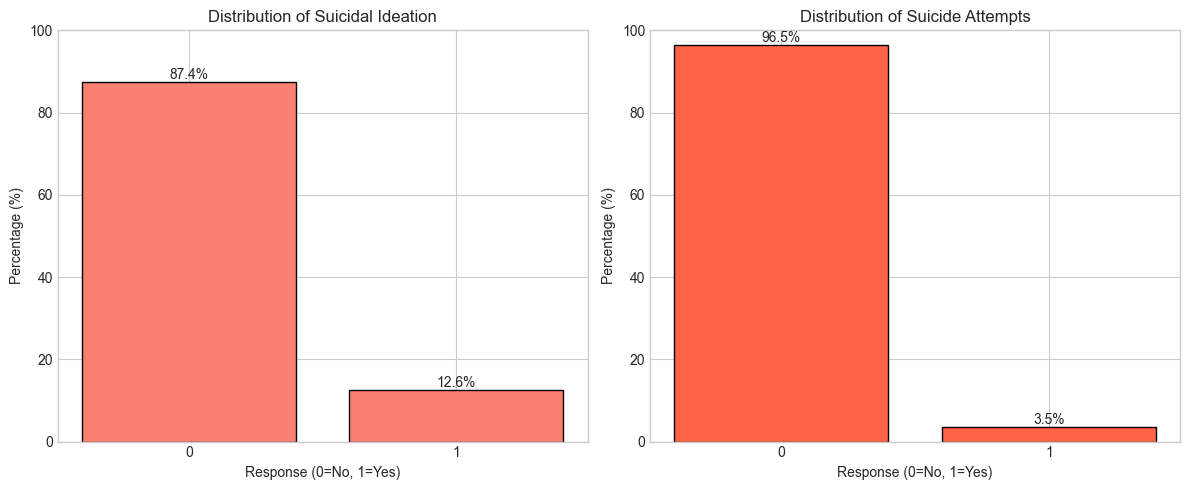

In [36]:
# Calculate percentages directly using normalize=True
ideation_pct = eda_df['suicidal_ideation'].value_counts(normalize=True).sort_index() * 100
attempt_pct = eda_df['suicide_attempt'].value_counts(normalize=True).sort_index() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Suicidal Ideation
bars1 = ax1.bar(ideation_pct.index.astype(str), ideation_pct.values, color='salmon', edgecolor='black')
ax1.set_title('Distribution of Suicidal Ideation')
ax1.set_xlabel('Response (0=No, 1=Yes)')
ax1.set_ylabel('Percentage (%)')  # Updated label
ax1.set_ylim(0, 100) # Set limit to 100 for context

# Plot Suicide Attempt
bars2 = ax2.bar(attempt_pct.index.astype(str), attempt_pct.values, color='tomato', edgecolor='black')
ax2.set_title('Distribution of Suicide Attempts')
ax2.set_xlabel('Response (0=No, 1=Yes)')
ax2.set_ylabel('Percentage (%)')  # Updated label
ax2.set_ylim(0, 100) # Set limit to 100 for context

# Optional: Add text labels on top of bars to show the exact number
for ax in [ax1, ax2]:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Univariate Distributions
Now we must explore the nature of the upbringing variables' distributions.
I have chosen the upbringing variables to be:

- **mother_present:** If there is a mother figure in the house.
- **father_present:** If there is a father figure in the house.
- **parental_warmth:** Parental warmth index.
- **parental_monitoring:** Parental monitoring index.
- **ace_victim:** Adverse childhood events.
- **mother_edu_cat:** The latest level of education the mother has acquired.

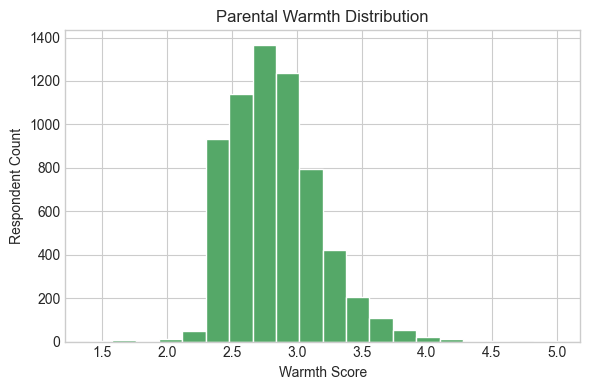

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(main_df["parental_warmth"].dropna(), bins=20, color="#55a868", edgecolor="white")
ax.set_title("Parental Warmth Distribution")
ax.set_xlabel("Warmth Score")
ax.set_ylabel("Respondent Count")
fig.tight_layout()
plt.show()

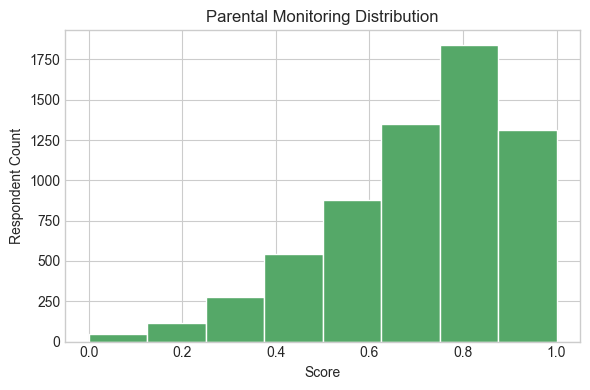

In [38]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(main_df["parental_monitoring"].dropna(), bins= 8, color="#55a868", edgecolor="white")
ax.set_title("Parental Monitoring Distribution")
ax.set_xlabel("Score")
ax.set_ylabel("Respondent Count")
fig.tight_layout()
plt.show()

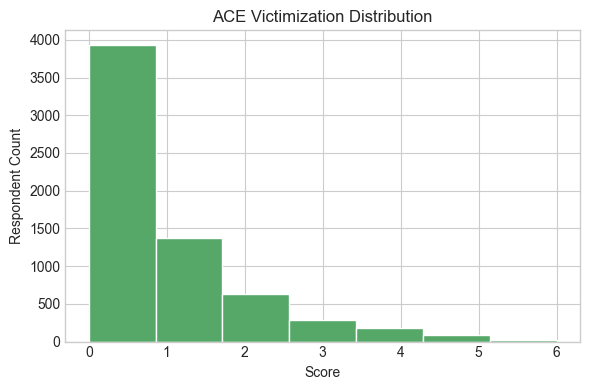

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(main_df["ace_victim"].dropna(), bins=7, color="#55a868", edgecolor="white")
ax.set_title("ACE Victimization Distribution")
ax.set_xlabel("Score")
ax.set_ylabel("Respondent Count")
fig.tight_layout()
plt.show()

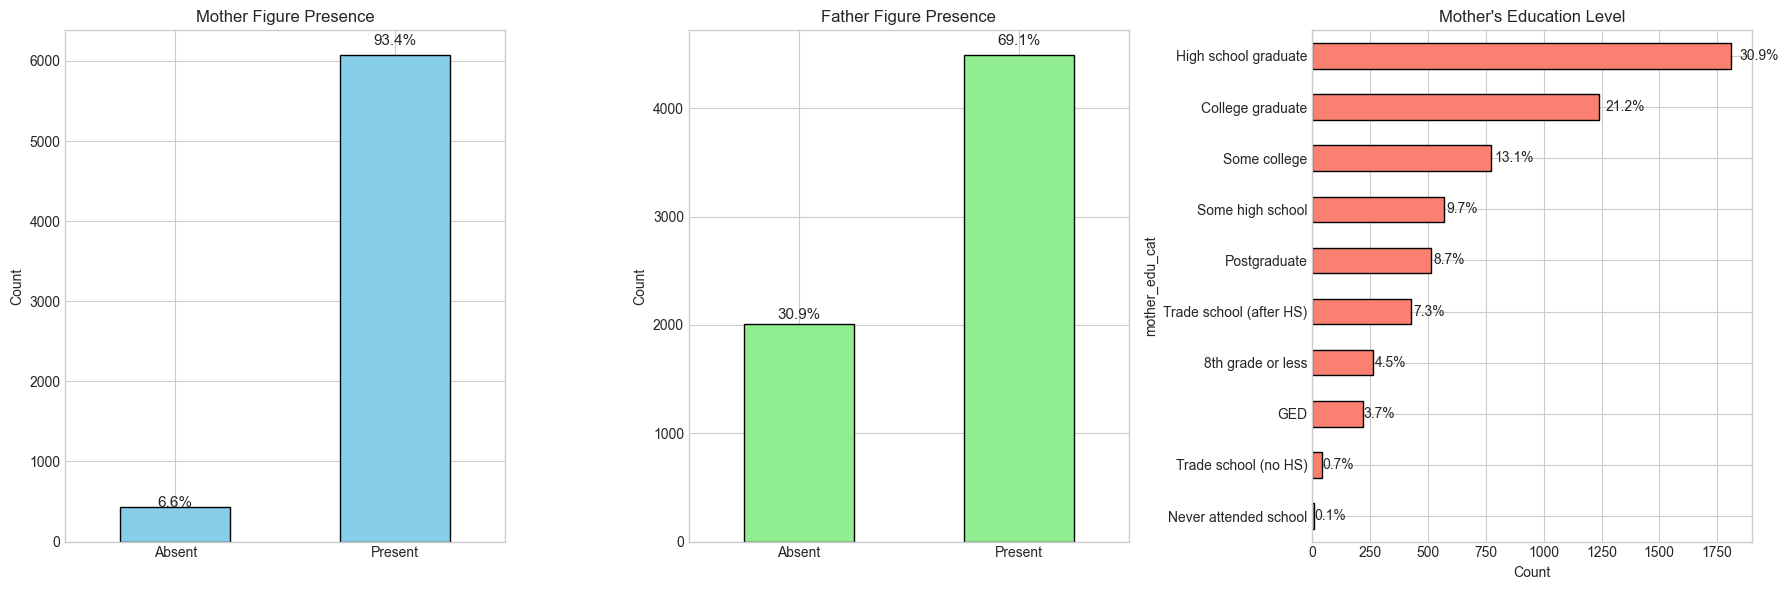

In [40]:
import matplotlib.pyplot as plt

# Set up the figure with 3 subplots side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# --- 1. Mother Presence ---
# Get Counts
counts_m = eda_df['mother_present'].value_counts().sort_index()
counts_m.index = ['Absent', 'Present']
total_m = len(eda_df['mother_present'].dropna()) # Total for percentages

# Plot Counts
counts_m.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')

# Add Percentage Labels
for i, v in enumerate(counts_m):
    pct = (v / total_m) * 100
    ax[0].text(i, v + (v * 0.02), f'{pct:.1f}%', ha='center', fontsize=11)

ax[0].set_title('Mother Figure Presence')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=0)

# --- 2. Father Presence ---
# Get Counts
counts_f = eda_df['father_present'].value_counts().sort_index()
counts_f.index = ['Absent', 'Present']
total_f = len(eda_df['father_present'].dropna())

# Plot Counts
counts_f.plot(kind='bar', ax=ax[1], color='lightgreen', edgecolor='black')

# Add Percentage Labels
for i, v in enumerate(counts_f):
    pct = (v / total_f) * 100
    ax[1].text(i, v + (v * 0.02), f'{pct:.1f}%', ha='center', fontsize=11)

ax[1].set_title('Father Figure Presence')
ax[1].set_ylabel('Count')
ax[1].tick_params(axis='x', rotation=0)

# --- 3. Mother's Education ---
# Get Counts (Sorted by value so the chart looks organized)
counts_e = eda_df['mother_edu_cat'].value_counts().sort_values(ascending=True)
total_e = len(eda_df['mother_edu_cat'].dropna())

# Plot Counts (Horizontal)
counts_e.plot(kind='barh', ax=ax[2], color='salmon', edgecolor='black')

# Add Percentage Labels (logic is slightly different for horizontal bars)
for index, value in enumerate(counts_e):
    pct = (value / total_e) * 100
    # Place text to the right of the bar (value + offset)
    ax[2].text(value + (value * 0.02), index, f'{pct:.1f}%', va='center', fontsize=10)

ax[2].set_title("Mother's Education Level")
ax[2].set_xlabel('Count')

plt.tight_layout()
plt.show()

## Analysis and Next Steps taken:

- **Parental Warmth:** Right-skewed distribution, median is 2.82 (out of 6)
which means less respondants acquire high parental warmth.
- **Parental Monitoring:** Left-skewed distribution, median is 0.71 (out of 1)
which means more respondants are exposed to high parental monitoring
- **ACE Victimization:** very right-skewed, with most respondants not being exposed, or exposed to some ACEs.
- **Parental Figure Presence:** Mothers are present in pretty much every household, yet some households can be considered to be ran by single mothers (~30% of the houses have no father figure)
- **Mother's Education:** ~40% are highschool graduates, which shows a dominance of mothers with moderate education, while college graduates are at ~20%, which is the 2nd most frequent education level.

## Bivareate Relationships

Now we shall explore the relationship between our upbringing variables and suicide ideation, by plotting them against two groups:

- **Ideators**
- **Non-Ideators**

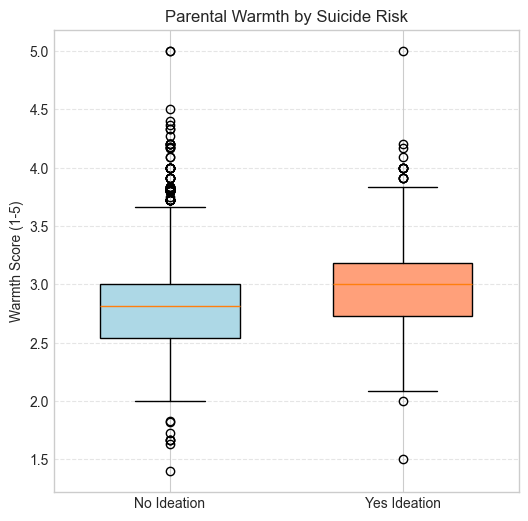

--- Statistics for parental_warmth ---
Median Warmth (No Ideation):  2.82
Median Warmth (Yes Ideation): 3.00
Difference: -0.18


In [41]:
# 1. Prepare Data
col = 'parental_warmth'
data_no = eda_df[eda_df['suicidal_ideation'] == 0][col].dropna()
data_yes = eda_df[eda_df['suicidal_ideation'] == 1][col].dropna()

# 2. Plot
plt.figure(figsize=(6, 6))
bplot = plt.boxplot([data_no, data_yes], tick_labels=['No Ideation', 'Yes Ideation'], 
                    patch_artist=True, widths=0.6)

# Color styling
colors = ['lightblue', 'lightsalmon']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Parental Warmth by Suicide Risk')
plt.ylabel('Warmth Score (1-5)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. Print Statistics
print(f"--- Statistics for {col} ---")
print(f"Median Warmth (No Ideation):  {data_no.median():.2f}")
print(f"Median Warmth (Yes Ideation): {data_yes.median():.2f}")
print(f"Difference: {data_no.median() - data_yes.median():.2f}")

- Parental warmth is surprisingly higher for ideators, which is something counterintuitive, since warmth is usually preventative.
-  I speculate that this is reactive parenting, i.e. the parents behavior towards their children shifts once they observe a poor mental condition

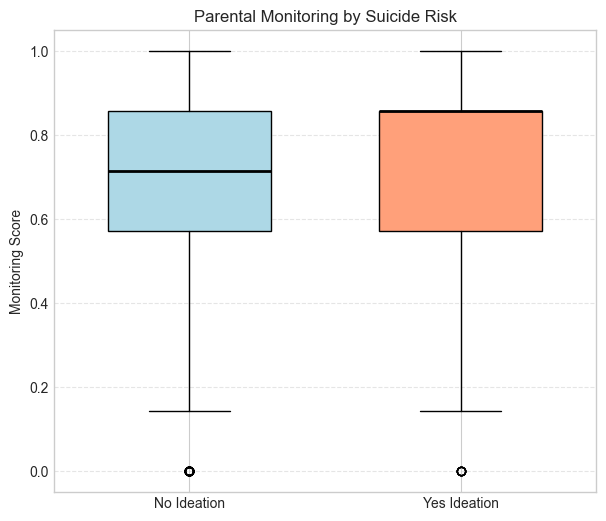

--- Statistics for parental_monitoring ---
Mean Monitoring (No Ideation):  0.73
Mean Monitoring (Yes Ideation): 0.74
Median Monitoring (No Ideation):  0.71
Median Monitoring (Yes Ideation): 0.86


In [42]:
# 1. Prepare Data
col = 'parental_monitoring'
data_no = eda_df[eda_df['suicidal_ideation'] == 0][col].dropna()
data_yes = eda_df[eda_df['suicidal_ideation'] == 1][col].dropna()

# 2. Plot
plt.figure(figsize=(7, 6))

# distinct changes: 
# added 'medianprops' to force the line to be Black and Thicker (linewidth=2)
bplot = plt.boxplot([data_no, data_yes], tick_labels=['No Ideation', 'Yes Ideation'], 
                    patch_artist=True, widths=0.6,
                    medianprops=dict(color="black", linewidth=2)) 

# Color styling (Light Blue vs Salmon)
colors = ['lightblue', 'lightsalmon']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Parental Monitoring by Suicide Risk')
plt.ylabel('Monitoring Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. Print Statistics
print(f"--- Statistics for {col} ---")
print(f"Mean Monitoring (No Ideation):  {data_no.mean():.2f}")
print(f"Mean Monitoring (Yes Ideation): {data_yes.mean():.2f}")
print(f"Median Monitoring (No Ideation):  {data_no.median():.2f}")
print(f"Median Monitoring (Yes Ideation): {data_yes.median():.2f}")

- Ideators are exposed to more parental monitoring

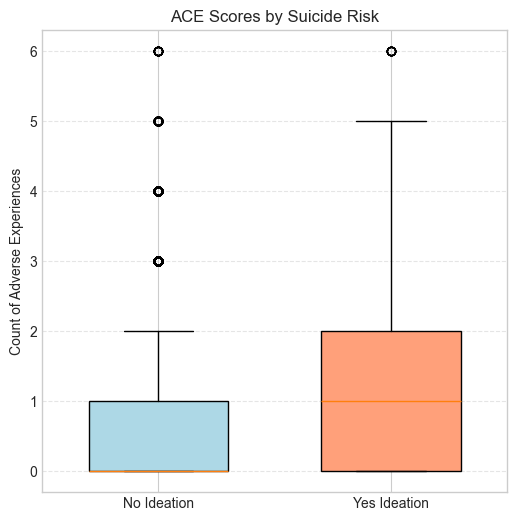

--- Statistics for ace_victim ---
Median ACEs (No Ideation):  0.00
Median ACEs (Yes Ideation): 1.00


In [43]:
# 1. Prepare Data
col = 'ace_victim'
data_no = eda_df[eda_df['suicidal_ideation'] == 0][col].dropna()
data_yes = eda_df[eda_df['suicidal_ideation'] == 1][col].dropna()

# 2. Plot
plt.figure(figsize=(6, 6))
bplot = plt.boxplot([data_no, data_yes], tick_labels=['No Ideation', 'Yes Ideation'], 
                    patch_artist=True, widths=0.6)

# Color styling
colors = ['lightblue', 'lightsalmon']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('ACE Scores by Suicide Risk')
plt.ylabel('Count of Adverse Experiences')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. Print Statistics
print(f"--- Statistics for {col} ---")
print(f"Median ACEs (No Ideation):  {data_no.median():.2f}")
print(f"Median ACEs (Yes Ideation): {data_yes.median():.2f}")

- about at least 50% of non ideators have and ace index = 0, and it is intuitive to see that ideators have a higher median and range

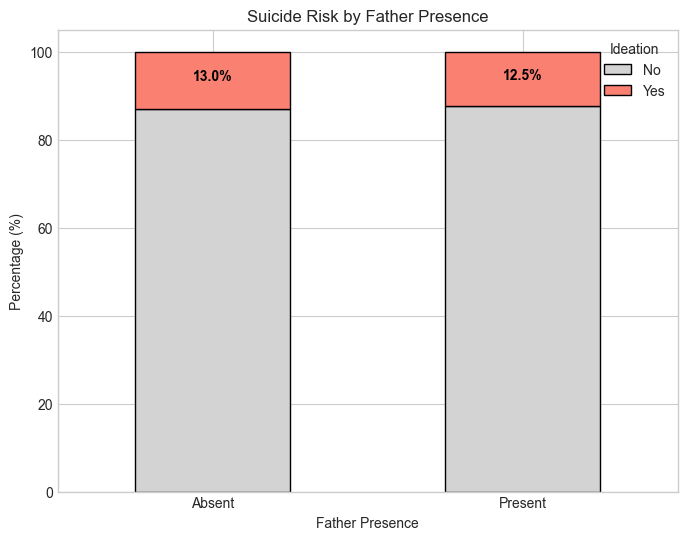

--- Risk Rates for father_present ---
Risk when Father Absent:  13.0%
Risk when Father Present: 12.5%


In [44]:
# 1. Calculate Cross-Tabulation
col = 'father_present'
ct = pd.crosstab(eda_df[col], eda_df['suicidal_ideation'], normalize='index') * 100

# 2. Plot
ax = ct.plot(kind='bar', stacked=True, color=['lightgray', 'salmon'], 
             figsize=(8, 6), edgecolor='black')

plt.title('Suicide Risk by Father Presence')
plt.ylabel('Percentage (%)')
plt.xlabel('Father Presence')
plt.xticks([0, 1], ['Absent', 'Present'], rotation=0)
plt.legend(title='Ideation', labels=['No', 'Yes'], loc='upper right')

# Add Labels
for n, x in enumerate(ct.index):
    risk_pct = ct.loc[x, 1]
    plt.text(n, 100 - (risk_pct/2), f'{risk_pct:.1f}%', ha='center', 
             color='black', fontweight='bold')

plt.show()

# 3. Print Statistics
print(f"--- Risk Rates for {col} ---")
print(f"Risk when Father Absent:  {ct.loc[0, 1]:.1f}%")
print(f"Risk when Father Present: {ct.loc[1, 1]:.1f}%")

<Figure size 800x600 with 0 Axes>

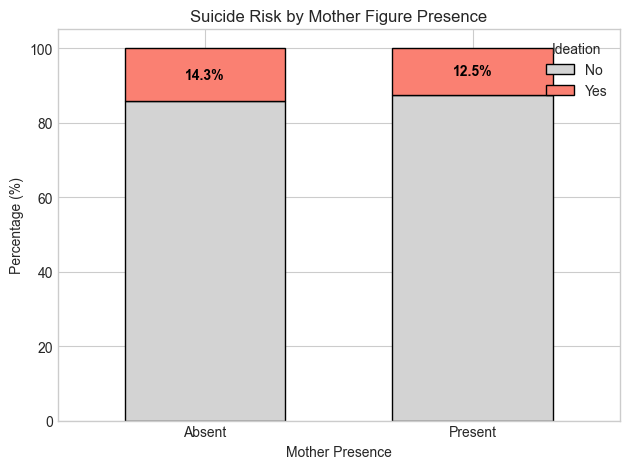

--- Risk Rates for mother_present ---
Risk when Mother Absent:  14.3%
Risk when Mother Present: 12.5%


In [45]:
# 1. Calculate Cross-Tabulation
# This creates a table showing the % of 'No' vs 'Yes' for Absent (0) and Present (1)
col = 'mother_present'
ct = pd.crosstab(eda_df[col], eda_df['suicidal_ideation'], normalize='index') * 100

# 2. Plot
plt.figure(figsize=(8, 6))
# Plotting the stacked bars: 0=Gray (No Ideation), 1=Salmon (Yes Ideation)
ax = ct.plot(kind='bar', stacked=True, color=['lightgray', 'salmon'], 
             edgecolor='black', width=0.6)

plt.title('Suicide Risk by Mother Figure Presence')
plt.ylabel('Percentage (%)')
plt.xlabel('Mother Presence')
# Replace 0/1 x-labels with text
plt.xticks([0, 1], ['Absent', 'Present'], rotation=0)
plt.legend(title='Ideation', labels=['No', 'Yes'], loc='upper right')

# 3. Add Percentage Labels to the "Yes" (Red) section
for n, x in enumerate(ct.index):
    risk_pct = ct.loc[x, 1]
    # Place text in the middle of the red bar section
    plt.text(n, 100 - (risk_pct/2), f'{risk_pct:.1f}%', ha='center', va='center', 
             color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Print Statistics
print(f"--- Risk Rates for {col} ---")
# Check if we actually have data for both groups (0 and 1) before printing
if 0 in ct.index:
    print(f"Risk when Mother Absent:  {ct.loc[0, 1]:.1f}%")
else:
    print("Risk when Mother Absent:  No data available")

if 1 in ct.index:
    print(f"Risk when Mother Present: {ct.loc[1, 1]:.1f}%")

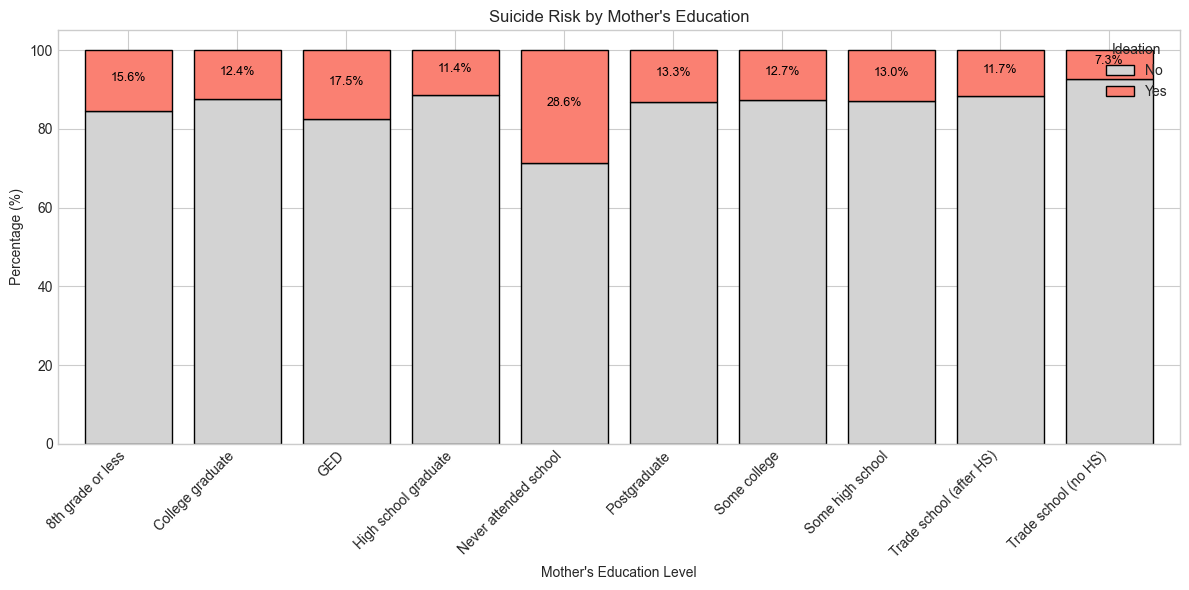

--- Risk Rates for mother_edu_cat (Top 3 & Bottom 3) ---
mother_edu_cat
Never attended school     28.57
GED                       17.51
8th grade or less         15.59
Postgraduate              13.28
Some high school          13.03
Some college              12.73
College graduate          12.41
Trade school (after HS)   11.74
High school graduate      11.37
Trade school (no HS)       7.32
Name: 1, dtype: float64


In [46]:
# 1. Calculate Cross-Tabulation
col = 'mother_edu_cat'
ct = pd.crosstab(eda_df[col], eda_df['suicidal_ideation'], normalize='index') * 100

# Optional: Sort by education level if your categories are ordinal strings
# ct = ct.sort_values(by=...) # Only needed if the order looks wrong

# 2. Plot
ax = ct.plot(kind='bar', stacked=True, color=['lightgray', 'salmon'], 
             figsize=(12, 6), edgecolor='black', width=0.8)

plt.title("Suicide Risk by Mother's Education")
plt.ylabel('Percentage (%)')
plt.xlabel("Mother's Education Level")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ideation', labels=['No', 'Yes'], loc='upper right')

# Add Labels (Only if risk > 2% to avoid clutter)
for n, x in enumerate(ct.index):
    risk_pct = ct.loc[x, 1]
    if risk_pct > 2:
        plt.text(n, 100 - (risk_pct/2), f'{risk_pct:.1f}%', ha='center', 
                 color='black', fontsize=9)

plt.tight_layout()
plt.show()

# 3. Print Statistics
print(f"--- Risk Rates for {col} (Top 3 & Bottom 3) ---")
print(ct[1].sort_values(ascending=False))

- Although repondants whom their mother's have never attended school show a risk of over 28%, the respondants with mothers with such educational background are only **0.1%**, which needs some repondants with suicidal ideation to make the number jump to 28%.

Thus, I have decided to merge groups to have a better, more consistent vizualization:

- Less than HS: Merge "Never attended," "8th grade or less," and "Some high school."

- HS Graduate: Keep as is, since it's the biggest group.

- Some College/Trade: Merge "GED," "Trade school," "Some college."

- College+: Merge "College graduate" and "Postgraduate."

In [47]:
# Create a mapping dictionary
edu_map = {
    'Never attended school': 'Less than HS',
    '8th grade or less': 'Less than HS',
    'Some high school': 'Less than HS',
    'GED': 'Some College/Trade',
    'Trade school (after HS)': 'Some College/Trade',
    'Trade school (no HS)': 'Some College/Trade', # Often grouped here or with Less than HS depending on rigor
    'Some college': 'Some College/Trade',
    'High school graduate': 'HS Grad',
    'College graduate': 'College Grads',
    'Postgraduate': 'College Grads'
}

# Apply the mapping
eda_df['mother_edu_grouped'] = eda_df['mother_edu_cat'].replace(edu_map)

# Check the new risk rates
print(pd.crosstab(eda_df['mother_edu_grouped'], eda_df['suicidal_ideation'], normalize='index') * 100)

suicidal_ideation      0     1
mother_edu_grouped            
College Grads      87.34 12.66
HS Grad            88.63 11.37
Less than HS       86.04 13.96
Some College/Trade 87.00 13.00


- Now we observe that respondants with mother's having reached a level of education less than High School have risk ~14%

### Now, for context variables
we are using them to tell if the effects of these upbringing factors for the 2 groups differ between 
socioeconomic statuses

I will not choose all the context variables for the modelling, since some might project the same results (like poverty level and median income of the block)
Usually a high median income within a block should reflect a block that has low poverty, thus they are negatively correlated.
If the negative correlation is strong, then using both variables would be redundant, else, then using these 2 varaible would reflect more naunce.

Upbringing variables I shall plot against the context variables chosen:

- **ACE Victimization:** since that can also tell how the neighborhood collectively interacts with ACEs (probably low-income neighborhoods, who are common to have security issues are conditioned to deal with ACEs on the level of all ages)
- **Parental Warmth:** since this variable initially showed unexpected results (more warmth acquired by ideators), it should be deeply investigated
- **Parental Monitoring:** since it is a strong indicator for ideators
- **Mother's Education:** especially for the group of less than highschool education, since it owes the highest risk
and it turned out that father/mother's presence/absence technically does not affect the main variable, so it will not be significant in the context study.

In [48]:
# Check the correlation between Income and Poverty, Pearson correlation coefficient
correlation = eda_df['Med_Income'].corr(eda_df['Poverty_density'])

print(f"Correlation between Income and Poverty: {correlation:.2f}")

Correlation between Income and Poverty: -0.67


- so both are highly correlated, thus I will stick to median income of the block

In [49]:
# 1. Create Income Groups (Tertiles)
# This splits your data into 3 equal-sized chunks based on wealth
eda_df['Income_Group'] = pd.qcut(eda_df['Med_Income'], q=3, 
                                 labels=['Low Income', 'Medium Income', 'High Income'])

# Check the counts to ensure it worked
print("--- Counts per Income Group ---")
print(eda_df['Income_Group'].value_counts())

--- Counts per Income Group ---
Income_Group
Low Income       2000
Medium Income    1955
High Income      1845
Name: count, dtype: int64


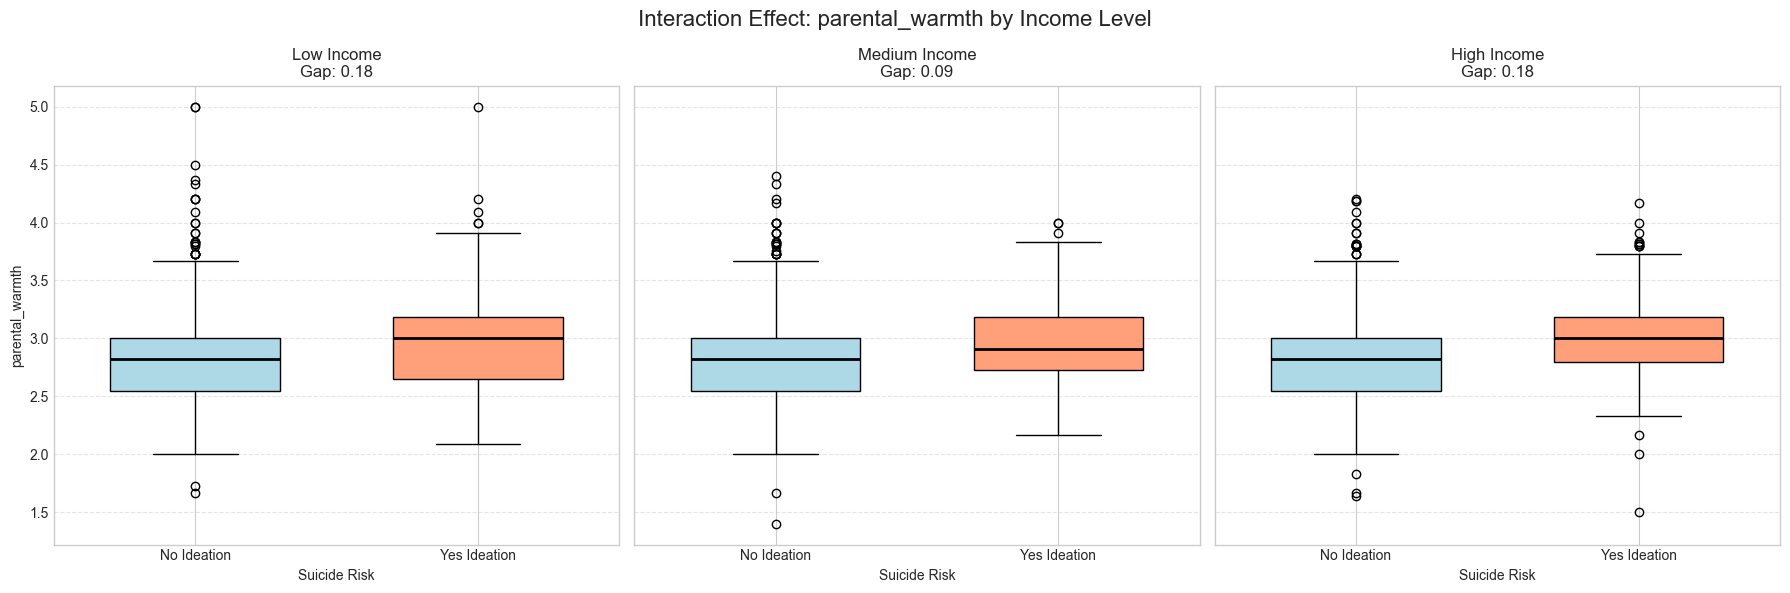

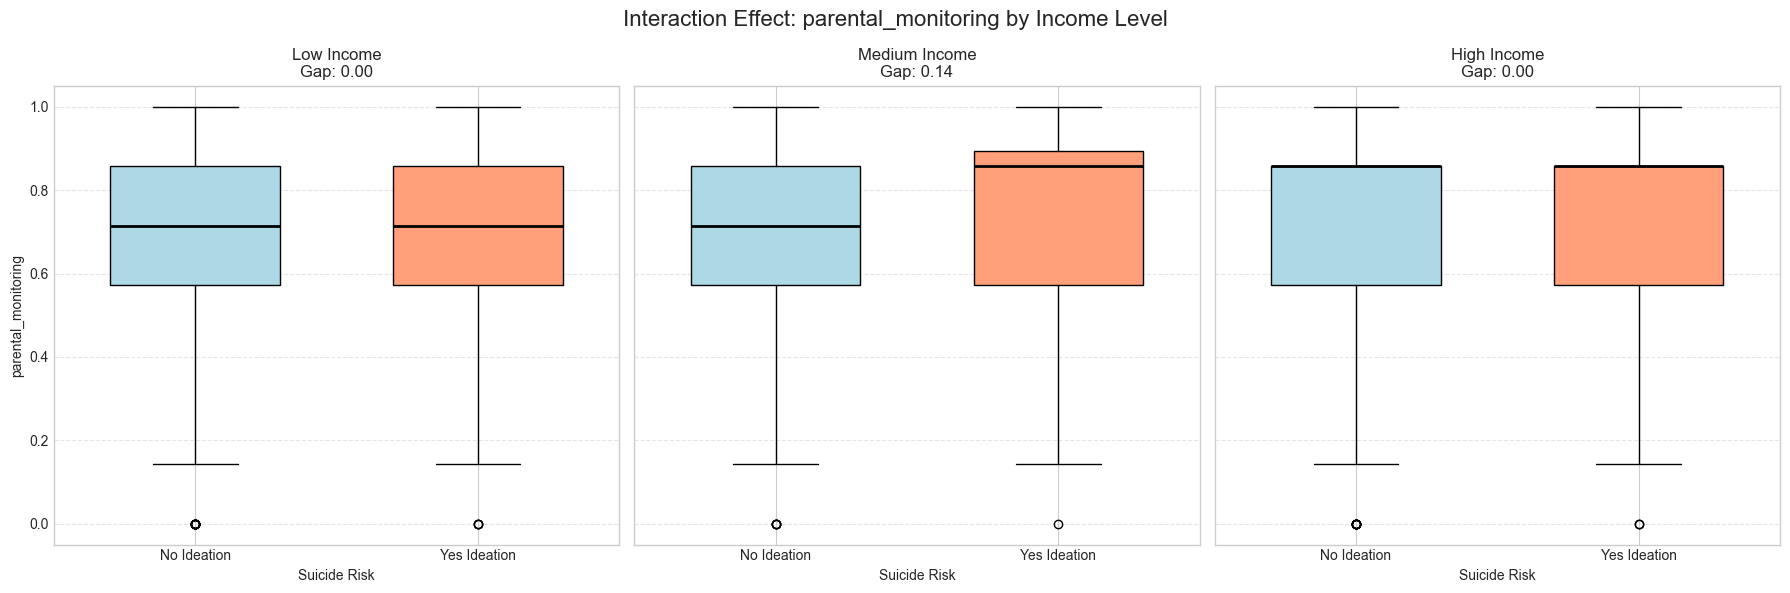

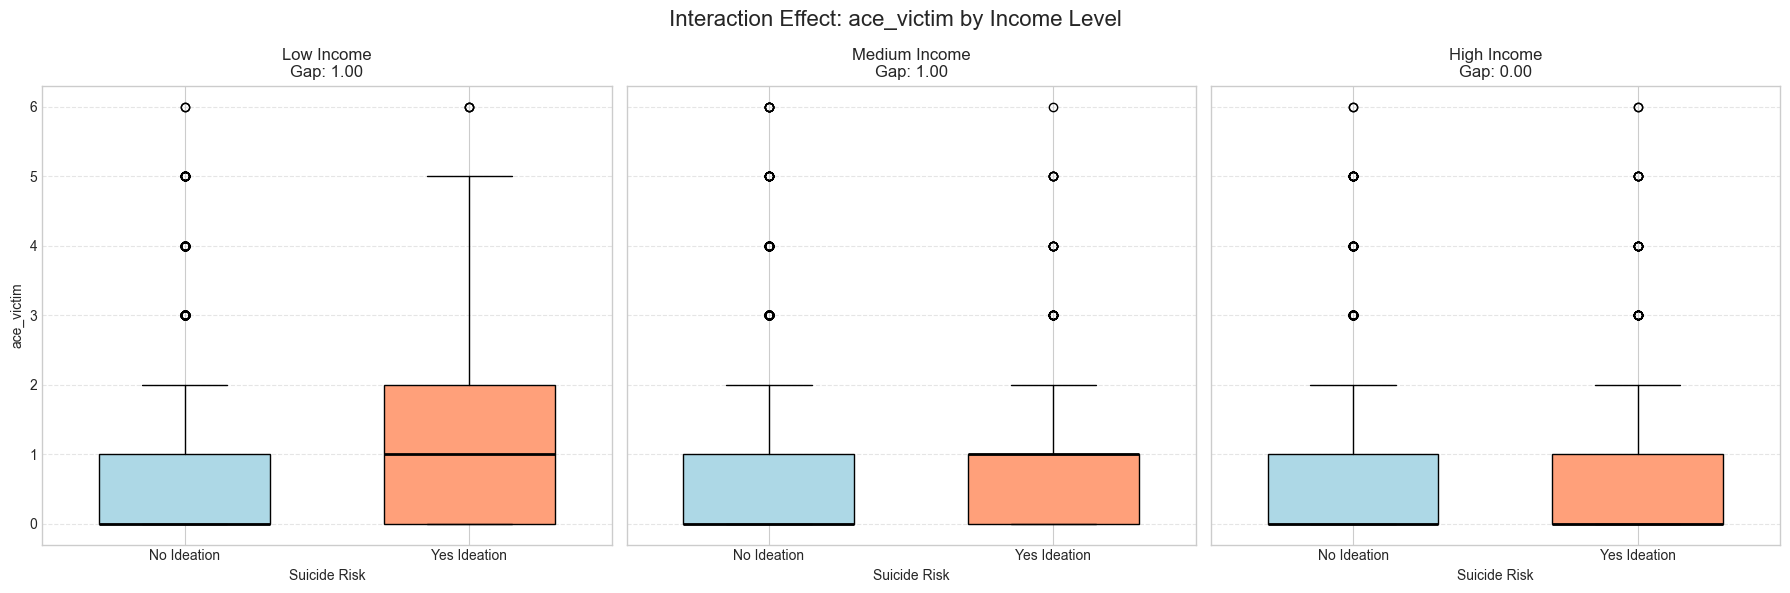

In [50]:
# List of variables to check against Income
check_vars = ['parental_warmth', 'parental_monitoring', 'ace_victim']

# Loop through each variable
for col in check_vars:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop through the 3 Income Groups (Low -> Medium -> High)
    groups = ['Low Income', 'Medium Income', 'High Income']
    
    for i, group in enumerate(groups):
        # Filter data for THIS income group only
        subset = eda_df[eda_df['Income_Group'] == group]
        
        # Split into Suicide No (0) vs Yes (1)
        data_no = subset[subset['suicidal_ideation'] == 0][col].dropna()
        data_yes = subset[subset['suicidal_ideation'] == 1][col].dropna()
        
        # Create Boxplot
        # We manually set the median line to Black so you can see it clearly
        bplot = axes[i].boxplot([data_no, data_yes], tick_labels=['No Ideation', 'Yes Ideation'], 
                                patch_artist=True, widths=0.6,
                                medianprops=dict(color="black", linewidth=2))
        
        # Color styling
        colors = ['lightblue', 'lightsalmon']
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        
        # Calculate the Median Gap (Difference between Suicidal vs Non-Suicidal)
        # This number tells you "How big is the effect?" in this specific income group
        if len(data_yes) > 0 and len(data_no) > 0:
            gap = data_yes.median() - data_no.median()
        else:
            gap = 0
            
        # Titles and Labels
        axes[i].set_title(f'{group}\nGap: {gap:.2f}')
        axes[i].set_xlabel('Suicide Risk')
        axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Set the Y-label only on the first plot
    axes[0].set_ylabel(col)
    plt.suptitle(f'Interaction Effect: {col} by Income Level', fontsize=16)
    plt.tight_layout()
    plt.show()

## Analysis of the results:
- **ACE Victimization:** In Low and Medium income groups, the gap is 1 (Suicidal teens have significantly more trauma). In the High income group, the gap is 0.
- **conclusion:** Trauma is a strong predictor of suicide in lower-socioeconomic environments, but in wealthy neighborhoods, suicidal ideation appears to be driven by factors other than cumulative trauma (or wealthy teens are insulated from the types of ACEs measured here).

- **Parental Monitoring:** The gap is 0 for both Poor and Rich. It only spikes to 0.14 for the Middle Class.
- **conclusion:** Higher parental monitoring correlates with suicidal ideation (reactive parenting) only in middle-income households. In both low- and high-income extremes, monitoring levels do not distinguish between suicidal and non-suicidal adolescents.

- **Parental Warmth:** The gap exists across all three groups (0.18 $\to$ 0.09 $\to$ 0.18).
- **conclusion:** Parental warmth remains a consistent differentiating factor across all socioeconomic levels, though the distinction is slightly less pronounced in middle-income families.

- Now I wanted to see if the effect of low education for mothers is just the effect of an impovereished block, since if you have low education, then this usually does not nominate you to have a high-paying job; or if that is directly related to the parent's education, since, usually uneducated mothers may not offer healthy parenting, and that determination will tell if the mother's education variable is redundant or
if it provides more information

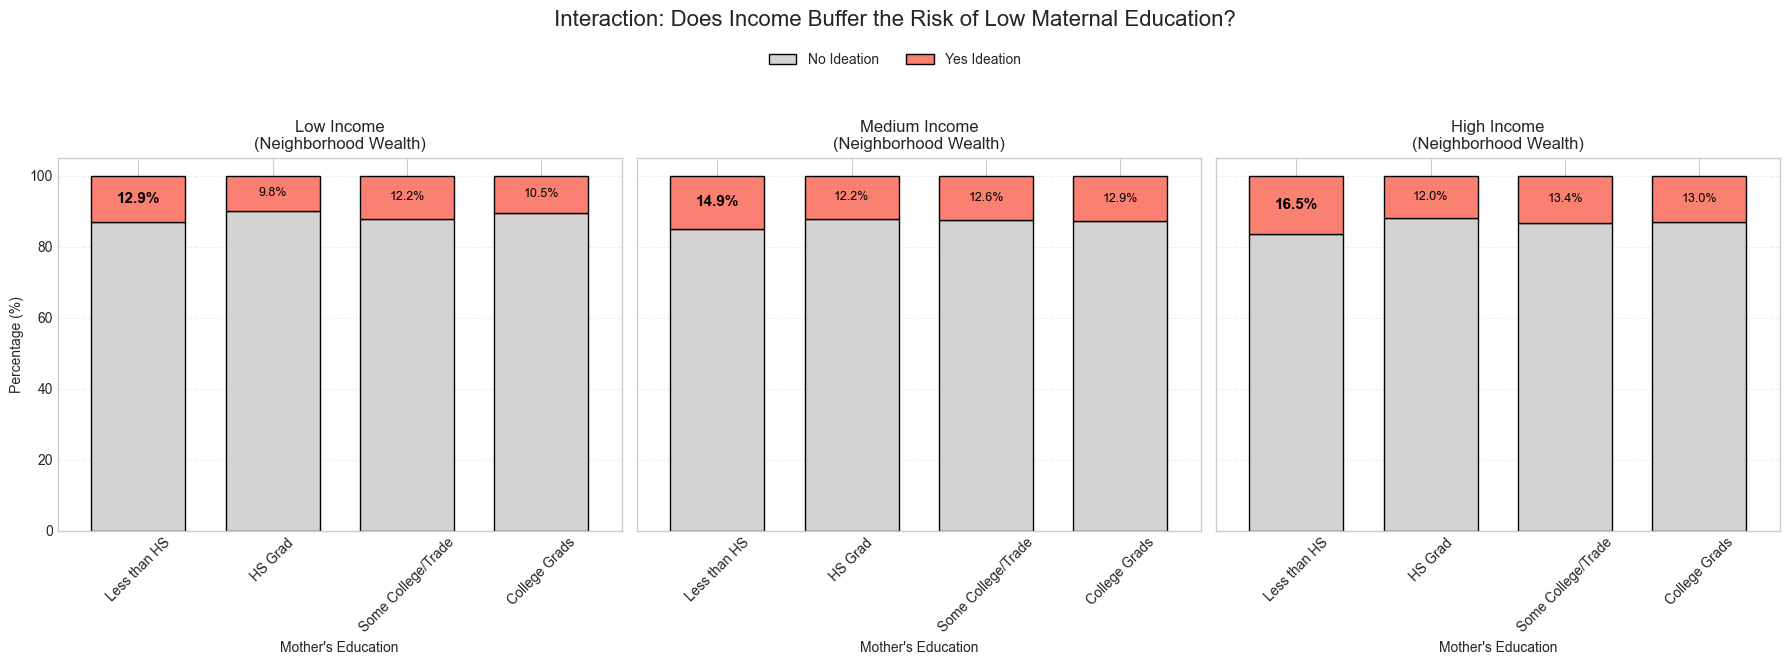

In [51]:
groups = ['Low Income', 'Medium Income', 'High Income']
custom_order = ['Less than HS', 'HS Grad', 'Some College/Trade', 'College Grads']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# 4. Loop through Income Groups
for i, group in enumerate(groups):
    # Filter for this income group
    subset = eda_df[eda_df['Income_Group'] == group]
    
    # Create Cross-Tabulation (Risk %)
    if not subset.empty:
        ct = pd.crosstab(subset['mother_edu_grouped'], subset['suicidal_ideation'], normalize='index') * 100
        
        # Reorder rows so "Less than HS" is always first/left
        ct = ct.reindex(custom_order)
        
        # Plot
        ct.plot(kind='bar', stacked=True, color=['lightgray', 'salmon'], 
                ax=axes[i], edgecolor='black', width=0.7, legend=False)
        
        # Add Percentage Labels
        for n, x in enumerate(ct.index):
            if 1 in ct.columns:
                risk_pct = ct.loc[x, 1]
                # Highlight the "Less than HS" bar specifically
                if x == 'Less than HS':
                    axes[i].text(n, 100 - (risk_pct/2), f'{risk_pct:.1f}%', 
                                 ha='center', va='center', color='black', fontweight='bold', fontsize=11)
                elif risk_pct > 2:
                    axes[i].text(n, 100 - (risk_pct/2), f'{risk_pct:.1f}%', 
                                 ha='center', va='center', color='black', fontsize=9)
    
    # Styling
    axes[i].set_title(f'{group}\n(Neighborhood Wealth)')
    axes[i].set_xlabel("Mother's Education")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)

# Common Labels
axes[0].set_ylabel('Percentage (%)')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['No Ideation', 'Yes Ideation'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.suptitle("Interaction: Does Income Buffer the Risk of Low Maternal Education?", y=1.1, fontsize=16)
plt.tight_layout()
plt.show()

In [52]:
# Check the counts for Mother's Education inside the High Income group
high_income = eda_df[eda_df['Income_Group'] == 'High Income']

print("--- Counts in High Income Group ---")
print(high_income['mother_edu_grouped'].value_counts())

--- Counts in High Income Group ---
mother_edu_grouped
College Grads         749
Some College/Trade    439
HS Grad               425
Less than HS           97
Name: count, dtype: int64


- **Analysis:** Mother's education remain to be an indicator for suicidal  risk, yet the higher the income, the more the risk.
I believe that is due to inconsistency; for a household administrated by an uneducated woman, the differences of the children (the respondants) appear between them and their other peers in that rich neighborhood that were raised by educated women. This could create stigma, because of these children/their whole family, are educationwise outliers.

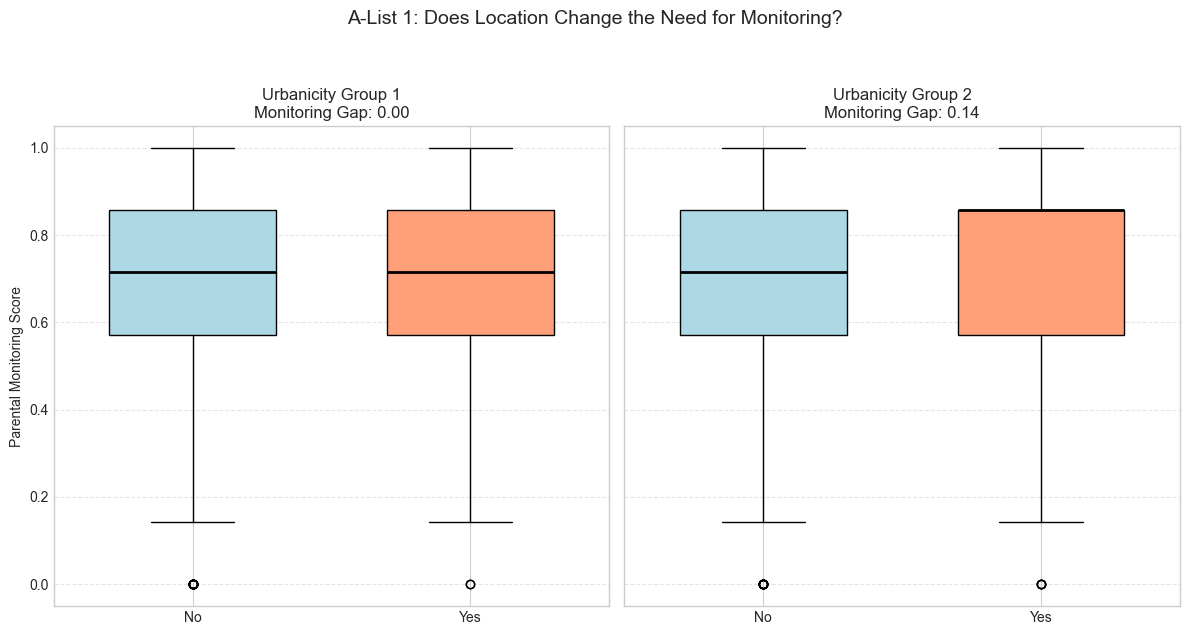

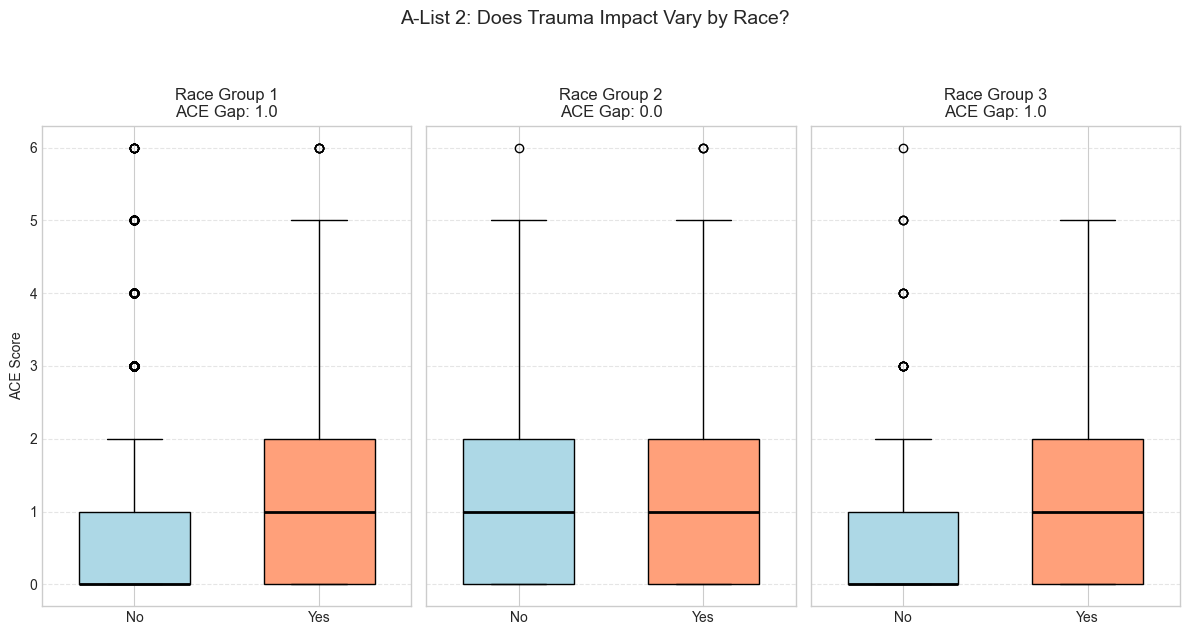

In [53]:
# Define colors for consistency
colors = ['lightblue', 'lightsalmon']
custom_order = ['Less than HS', 'HS Grad', 'Some College/Trade', 'College Grads']

# ==============================================================================
# 1. PARENTAL MONITORING vs. URBANICITY (Boxplot)
# Theory: Monitoring might be less critical in rural areas ("Free-range parenting").
# ==============================================================================
urban_groups = sorted(eda_df['Urbanicity'].dropna().unique())
fig, axes = plt.subplots(1, len(urban_groups), figsize=(12, 6), sharey=True)

for i, group in enumerate(urban_groups):
    subset = eda_df[eda_df['Urbanicity'] == group]
    ax = axes[i] if len(urban_groups) > 1 else axes
    
    if len(subset) > 20:
        data_no = subset[subset['suicidal_ideation'] == 0]['parental_monitoring'].dropna()
        data_yes = subset[subset['suicidal_ideation'] == 1]['parental_monitoring'].dropna()
        
        bplot = ax.boxplot([data_no, data_yes], tick_labels=['No', 'Yes'], 
                           patch_artist=True, widths=0.6,
                           medianprops=dict(color="black", linewidth=2))
        
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
            
        gap = data_yes.median() - data_no.median() if len(data_yes) > 0 else 0
        
        # Generic label if codebook is unknown, typically 1=Urban, 2=Rural (or similar)
        ax.set_title(f'Urbanicity Group {int(group)}\nMonitoring Gap: {gap:.2f}')
        ax.grid(axis='y', linestyle='--', alpha=0.5)

axes[0].set_ylabel('Parental Monitoring Score')
plt.suptitle('A-List 1: Does Location Change the Need for Monitoring?', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# ==============================================================================
# 2. ACEs vs. RACE (Boxplot)
# Theory: Does systemic racism compound the effect of trauma?
# ==============================================================================
race_groups = sorted(eda_df['Mod_Race'].dropna().unique())
n_races = len(race_groups)
fig, axes = plt.subplots(1, n_races, figsize=(4 * n_races, 6), sharey=True)

for i, group in enumerate(race_groups):
    subset = eda_df[eda_df['Mod_Race'] == group]
    ax = axes[i] if n_races > 1 else axes
    
    if len(subset) > 20:
        data_no = subset[subset['suicidal_ideation'] == 0]['ace_victim'].dropna()
        data_yes = subset[subset['suicidal_ideation'] == 1]['ace_victim'].dropna()
        
        bplot = ax.boxplot([data_no, data_yes], tick_labels=['No', 'Yes'], 
                           patch_artist=True, widths=0.6,
                           medianprops=dict(color="black", linewidth=2))
        
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
            
        gap = data_yes.median() - data_no.median() if len(data_yes) > 0 else 0
        
        ax.set_title(f'Race Group {int(group)}\nACE Gap: {gap:.1f}')
        ax.grid(axis='y', linestyle='--', alpha=0.5)
    else:
        ax.axis('off')

if n_races > 1: axes[0].set_ylabel('ACE Score')
plt.suptitle('A-List 2: Does Trauma Impact Vary by Race?', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

## Analysis:
- **Monitoring vs Urbanicity:** High monitoring is likely the norm for safety reasons. 
Since everyone does it, it doesn't predict who is suicidal. while high monitoring in the city is unusual, that is probably goes bakc to reactive parenting.

- **ACE vs Race:** For White and "Other" teens, cumulative trauma (ACEs) is a direct linear predictor of suicide risk.
For Black teens in this dataset, ACE scores do not distinguish between those who have ideation and those who don't. This suggests that there might be other predictors for black teens, or black communities have more resilience.

## Hypothesis Testing:

below are the codes used for testing certain hypothesis I have suggested base on the EDA patterns I have observed, this is a summary about these hypothesis and a determination of acceptance or rejections based on the tests I have implemented:

### General Summary:
- ACEs and Parental Warmth are the only highly significant predictors. They work consistently across almost all demographic groups.
- The "Context" Hypotheses Failed: The complex interactions I suspected—"Rural Monitoring," "Black Youth Resilience," and "Status Inconsistency"—did not survive statistical testing. The differences seen in the charts were not statistically significant ($p > 0.05$).
- Wealth itself ($p=0.059$) is borderline but not a strong direct predictor.

Below are more details about the hypotheses:

- Theory: Monitoring protects teens in Rural areas but is irrelevant in Urban areas.
- Test Result: REJECTED.
Urban: $P = 0.86$ (Not Significant)
Rural: $P = 0.13$ (Not Significant)
Conclusion: While the P-value dropped in rural areas (hinting at a trend), it did not reach the standard cutoff of 0.05. Statistically, we cannot claim that monitoring predicts suicide risk in either location. The gap you saw in the boxplot was likely sampling noise.

- Theory: Trauma (ACEs) predicts suicide for White youth but not for Black youth (due to protective buffering).
- Test Result: REJECTED.
White (Group 1): $P < 0.001$ (Highly Significant)
Black (Group 2): $P = 0.001$ (Significant)
Other (Group 3): $P = 0.049$ (* Significant)
Conclusion: Trauma is a significant predictor for ALL racial groups. While the visual gap looked smaller for Black youth, the math proves the relationship is still strong and real. There is no statistical evidence that Black youth are immune to the effects of ACEs in this dataset.

- Theory: Low maternal education is a distinct risk factor specifically in High-Income neighborhoods.
- Test Result: REJECTED.
Low Income: $P = 0.42$ (Not Significant)
Medium Income: $P = 0.76$ (Not Significant)
High Income: $P = 0.68$ (Not Significant)
Conclusion: The distribution of maternal education levels is statistically identical for suicidal and non-suicidal teens in all income brackets. The "higher risk" bar you saw in the High-Income chart was not statistically different from the others.

- Theory: Parental Warmth and ACEs matter regardless of income.
Test Result: CONFIRMED.
Warmth: Highly Significant ($P < 0.001$) in Low, Medium, and High Income.
ACEs: Highly Significant ($P < 0.001$) in Low and High Income; 
Significant ($P=0.002$) in Medium Income.

In [54]:
from scipy.stats import ttest_ind, chi2_contingency

# Setup: drop NaNs for the variables we are testing to avoid errors
# (We create a clean subset for testing purposes)
test_vars = ['suicidal_ideation', 'parental_warmth', 'parental_monitoring', 
             'ace_victim', 'mother_edu_grouped', 'Med_Income', 
             'Urbanicity', 'Mod_Race']
df_test = eda_df[test_vars].copy()

# Helper function to interpret p-values
def interpret(p):
    if p < 0.001: return "*** Highly Significant"
    if p < 0.01:  return "** Significant"
    if p < 0.05:  return "* Significant"
    return "Not Significant"

print("=========================================================")
print("      PART 1: MAIN EFFECTS (Global Bivariate Tests)")
print("=========================================================\n")

# --- 1A. Continuous Variables (T-TESTS) ---
continuous_vars = ['parental_warmth', 'parental_monitoring', 'ace_victim', 'Med_Income']

for var in continuous_vars:
    # Split the groups
    group_no = df_test[df_test['suicidal_ideation'] == 0][var].dropna()
    group_yes = df_test[df_test['suicidal_ideation'] == 1][var].dropna()
    
    # Run T-Test (equal_var=False handles unequal variances, which is safer)
    stat, p_val = ttest_ind(group_no, group_yes, equal_var=False)
    
    # Calculate Means for context
    mean_no = group_no.mean()
    mean_yes = group_yes.mean()
    
    print(f"-> {var}:")
    print(f"   Mean (No): {mean_no:.2f} | Mean (Yes): {mean_yes:.2f}")
    print(f"   P-value: {p_val:.4f} ({interpret(p_val)})")
    print("-" * 40)

# --- 1B. Categorical Variables (CHI-SQUARE) ---
# Mother's Education
ct = pd.crosstab(df_test['mother_edu_grouped'], df_test['suicidal_ideation'])
chi2, p_val, dof, expected = chi2_contingency(ct)

print(f"-> mother_edu_grouped:")
print(f"   P-value: {p_val:.4f} ({interpret(p_val)})")
print("-" * 40)


print("\n=========================================================")
print("      PART 2: CONTEXTUAL INTERACTIONS (Stratified)")
print("=========================================================\n")

# --- 2A. Monitoring by Urbanicity (T-TEST) ---
# Hypothesis: Monitoring is significant in Rural (2), maybe not Urban (1)
print("--- TEST: Monitoring split by Urbanicity ---")
urban_groups = sorted(df_test['Urbanicity'].dropna().unique())

for group in urban_groups:
    subset = df_test[df_test['Urbanicity'] == group]
    
    group_no = subset[subset['suicidal_ideation'] == 0]['parental_monitoring'].dropna()
    group_yes = subset[subset['suicidal_ideation'] == 1]['parental_monitoring'].dropna()
    
    if len(group_no) > 0 and len(group_yes) > 0:
        stat, p_val = ttest_ind(group_no, group_yes, equal_var=False)
        label = "Urban (1)" if group == 1 else "Rural (2)" # Adjust to your coding
        print(f"   {label}: P={p_val:.4f} ({interpret(p_val)})")
    else:
        print(f"   Group {group}: Not enough data")

# --- 2B. ACEs by Race (T-TEST) ---
# Hypothesis: ACEs significant for White/Other, but less so for Black
print("\n--- TEST: ACEs split by Race ---")
race_groups = sorted(df_test['Mod_Race'].dropna().unique())

for group in race_groups:
    subset = df_test[df_test['Mod_Race'] == group]
    
    group_no = subset[subset['suicidal_ideation'] == 0]['ace_victim'].dropna()
    group_yes = subset[subset['suicidal_ideation'] == 1]['ace_victim'].dropna()
    
    if len(group_no) > 20 and len(group_yes) > 20: # Ensure sample size
        stat, p_val = ttest_ind(group_no, group_yes, equal_var=False)
        print(f"   Race Group {int(group)}: P={p_val:.4f} ({interpret(p_val)})")
    else:
        print(f"   Race Group {int(group)}: Insufficient sample size")

# --- 2C. Mother's Edu by Income (CHI-SQUARE) ---
# Hypothesis: Education matters in High Income (Status Inconsistency)
print("\n--- TEST: Mother's Education split by Income Level ---")

# Create Income Groups (Tertiles) if not already present
if 'Income_Group' not in df_test.columns:
    df_test['Income_Group'] = pd.qcut(df_test['Med_Income'], q=3, 
                                      labels=['Low Income', 'Medium Income', 'High Income'])

income_groups = ['Low Income', 'Medium Income', 'High Income']

for group in income_groups:
    subset = df_test[df_test['Income_Group'] == group]
    
    ct = pd.crosstab(subset['mother_edu_grouped'], subset['suicidal_ideation'])
    
    if ct.size > 0:
        chi2, p_val, dof, expected = chi2_contingency(ct)
        print(f"   {group}: P={p_val:.4f} ({interpret(p_val)})")

      PART 1: MAIN EFFECTS (Global Bivariate Tests)

-> parental_warmth:
   Mean (No): 2.83 | Mean (Yes): 2.98
   P-value: 0.0000 (*** Highly Significant)
----------------------------------------
-> parental_monitoring:
   Mean (No): 0.73 | Mean (Yes): 0.74
   P-value: 0.2870 (Not Significant)
----------------------------------------
-> ace_victim:
   Mean (No): 0.68 | Mean (Yes): 1.13
   P-value: 0.0000 (*** Highly Significant)
----------------------------------------
-> Med_Income:
   Mean (No): 34494.79 | Mean (Yes): 35646.74
   P-value: 0.0591 (Not Significant)
----------------------------------------
-> mother_edu_grouped:
   P-value: 0.2518 (Not Significant)
----------------------------------------

      PART 2: CONTEXTUAL INTERACTIONS (Stratified)

--- TEST: Monitoring split by Urbanicity ---
   Urban (1): P=0.8613 (Not Significant)
   Rural (2): P=0.1275 (Not Significant)

--- TEST: ACEs split by Race ---
   Race Group 1: P=0.0000 (*** Highly Significant)
   Race Group 2: P=0.

In [55]:
# Define Income Groups (Tertiles) if not already present
if 'Income_Group' not in df_test.columns:
    df_test['Income_Group'] = pd.qcut(df_test['Med_Income'], q=3, 
                                      labels=['Low Income', 'Medium Income', 'High Income'])

print("\n=========================================================")
print("      PART 3: INCOME INTERACTIONS (Stratified)")
print("=========================================================\n")

variables_to_test = ['parental_warmth', 'parental_monitoring', 'ace_victim']
income_groups = ['Low Income', 'Medium Income', 'High Income']

for var in variables_to_test:
    print(f"--- Testing {var} by Income Level ---")
    
    for group in income_groups:
        subset = df_test[df_test['Income_Group'] == group]
        
        # Split Data
        group_no = subset[subset['suicidal_ideation'] == 0][var].dropna()
        group_yes = subset[subset['suicidal_ideation'] == 1][var].dropna()
        
        # Check sample size (Safety Check)
        if len(group_no) > 20 and len(group_yes) > 20:
            # Run T-Test
            stat, p_val = ttest_ind(group_no, group_yes, equal_var=False)
            
            # Formatting the output
            significance = "Not Significant"
            if p_val < 0.05: significance = "* Significant"
            if p_val < 0.01: significance = "** Significant"
            if p_val < 0.001: significance = "*** Highly Significant"
            
            # Print means to see the direction (e.g., Higher or Lower?)
            mean_diff = group_yes.mean() - group_no.mean()
            
            print(f"   {group}: P={p_val:.4f} ({significance}) | Diff: {mean_diff:.2f}")
        else:
            print(f"   {group}: Insufficient Data")
    
    print("-" * 40)


      PART 3: INCOME INTERACTIONS (Stratified)

--- Testing parental_warmth by Income Level ---
   Low Income: P=0.0000 (*** Highly Significant) | Diff: 0.17
   Medium Income: P=0.0000 (*** Highly Significant) | Diff: 0.12
   High Income: P=0.0000 (*** Highly Significant) | Diff: 0.17
----------------------------------------
--- Testing parental_monitoring by Income Level ---
   Low Income: P=0.4380 (Not Significant) | Diff: 0.01
   Medium Income: P=0.0901 (Not Significant) | Diff: 0.02
   High Income: P=0.4447 (Not Significant) | Diff: -0.01
----------------------------------------
--- Testing ace_victim by Income Level ---
   Low Income: P=0.0000 (*** Highly Significant) | Diff: 0.55
   Medium Income: P=0.0023 (** Significant) | Diff: 0.25
   High Income: P=0.0000 (*** Highly Significant) | Diff: 0.45
----------------------------------------


In [56]:
# Ensure Income Groups exist
if 'Income_Group' not in df_test.columns:
    df_test['Income_Group'] = pd.qcut(df_test['Med_Income'], q=3, 
                                      labels=['Low Income', 'Medium Income', 'High Income'])

print("\n=========================================================")
print("      PART 4: MOTHER'S EDUCATION by INCOME (Chi-Square)")
print("=========================================================\n")

income_groups = ['Low Income', 'Medium Income', 'High Income']

for group in income_groups:
    subset = df_test[df_test['Income_Group'] == group]
    
    # Create the Contingency Table (Education vs. Suicide)
    ct = pd.crosstab(subset['mother_edu_grouped'], subset['suicidal_ideation'])
    
    # Run Chi-Square Test
    # This tests if the distribution of suicide risk differs by education level WITHIN this income group
    if ct.size > 0:
        chi2, p_val, dof, expected = chi2_contingency(ct)
        
        # Interpret Significance
        significance = "Not Significant"
        if p_val < 0.05: significance = "* Significant"
        if p_val < 0.01: significance = "** Significant"
        
        print(f"--- {group} ---")
        print(f"   P-value: {p_val:.4f} ({significance})")
        
        # Optional: Print the risk % for "Less than HS" to see the direction
        # (This helps check if the high-income risk is actually higher)
        if 'Less than HS' in ct.index:
            risk = ct.loc['Less than HS', 1] / ct.loc['Less than HS'].sum() * 100
            print(f"   Risk for 'Less than HS': {risk:.1f}%")
    else:
        print(f"--- {group} ---")
        print("   Insufficient Data")


      PART 4: MOTHER'S EDUCATION by INCOME (Chi-Square)

--- Low Income ---
   P-value: 0.4160 (Not Significant)
   Risk for 'Less than HS': 12.9%
--- Medium Income ---
   P-value: 0.7562 (Not Significant)
   Risk for 'Less than HS': 14.9%
--- High Income ---
   P-value: 0.6838 (Not Significant)
   Risk for 'Less than HS': 16.5%


# Logistic Model for predicting Ideation:

--- Cross-Validation Performance ---
Recall Scores for each fold: [0.59292035 0.55752212 0.57522124 0.53982301 0.45614035]
Average Recall: 0.54

--- Final Test Set Evaluation ---
              precision    recall  f1-score   support

           0       0.91      0.62      0.74       997
           1       0.18      0.57      0.27       142

    accuracy                           0.62      1139
   macro avg       0.54      0.60      0.51      1139
weighted avg       0.82      0.62      0.68      1139



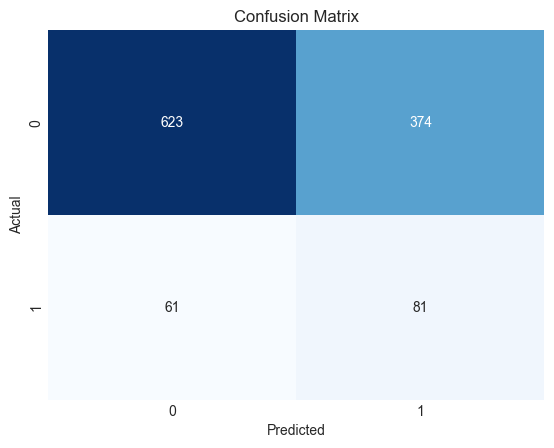

ROC-AUC Score: 0.6469


In [57]:
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# 1. Prepare the Data
# We select ONLY the variables proven to matter + the target
ml_cols = ['suicidal_ideation', 'ace_victim', 'parental_warmth', 'Med_Income']
df_ml = eda_df[ml_cols].dropna().copy()

# Define X (Features) and y (Target)
X = df_ml.drop('suicidal_ideation', axis=1)
y = df_ml['suicidal_ideation']

# 2. Feature Engineering: Scaling (Recitation Topic)
# Logistic Regression performs best when features are on the same scale (e.g., mean 0, std 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for readability (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 3. Train/Test Split (Recitation Topic)
# We keep 20% of data unseen to test the final model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 4. Initialize Logistic Regression (Recitation Topic)
# class_weight='balanced' is CRITICAL here. 
# It tells the model: "Pay more attention to the Suicidal class because it is smaller."
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# 5. K-Fold Cross-Validation (Recitation Topic)
# We test the model on 5 different "folds" of the training data to check stability
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=kfold, scoring='recall')

print(f"--- Cross-Validation Performance ---")
print(f"Recall Scores for each fold: {cv_scores}")
print(f"Average Recall: {cv_scores.mean():.2f}")

# 6. Final Fit and Prediction
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1] # Probability estimates

# 7. Evaluation Metrics (Recitation Topic)
print("\n--- Final Test Set Evaluation ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# AUC Score
auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {auc:.4f}")

## Commentation:
The model catches a decent number of at risk kids, but to do so, it flags a lot of safe kids as "at risk".
- It found **57%** of the suicidal teens using just three variables. (Income, Warmth, ACE victimization)
- if we pick one random suicidal teen and one random non-suicidal teen, the model will score the suicidal one higher **65%** of the time.


--- Feature Interpretation (Slopes) ---
           Feature  Coefficient (Log-Odds)  Odds Ratio
1  parental_warmth                    0.40        1.50
0       ace_victim                    0.28        1.33
2       Med_Income                    0.08        1.08


C:\Users\user\AppData\Local\Temp\ipykernel_21892\3987062131.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Odds Ratio', y='Feature', data=feature_importance, palette='viridis')


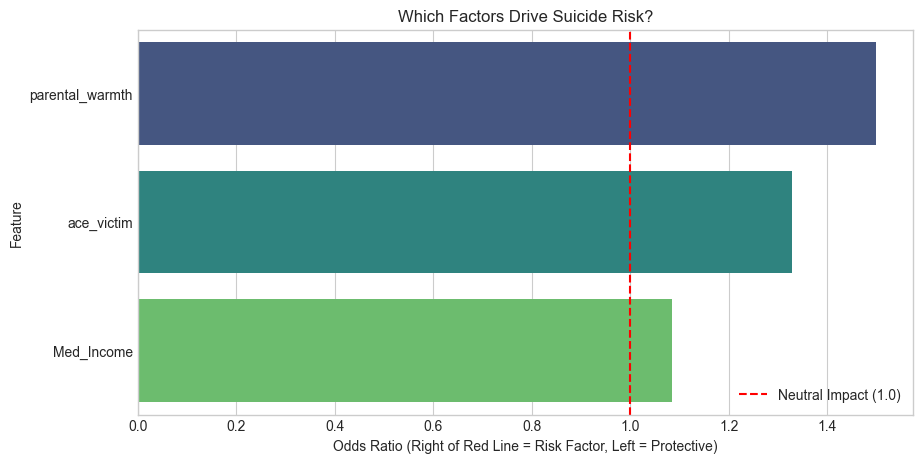

In [58]:
# Extract the coefficients (weights) assigned by the model
coefficients = log_reg.coef_[0]
features = X.columns

# Create a clean DataFrame to view them
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient (Log-Odds)': coefficients})

# Calculate Odds Ratios (Easier to interpret)
# e.g., Odds Ratio of 1.5 means "1 unit increase raises risk by 50%"
feature_importance['Odds Ratio'] = np.exp(feature_importance['Coefficient (Log-Odds)'])

# Sort by impact
feature_importance = feature_importance.sort_values(by='Odds Ratio', ascending=False)

print("--- Feature Interpretation (Slopes) ---")
print(feature_importance)

# Visualizing the Impact
plt.figure(figsize=(10, 5))
sns.barplot(x='Odds Ratio', y='Feature', data=feature_importance, palette='viridis')
plt.axvline(x=1, color='red', linestyle='--', label='Neutral Impact (1.0)')
plt.title('Which Factors Drive Suicide Risk?')
plt.xlabel('Odds Ratio (Right of Red Line = Risk Factor, Left = Protective)')
plt.legend()
plt.show()

# Final Conclusions:

I have built the model with the surviving variables, after a lengthy and intricate process of data selection and cleaning, and after filtering out computed variables with EDA and Hypothesis Testing,  I was remained with 3 variables: **Parental Warmth**, **ACE Victimization**, and **Median Income** (the latter being a context variable).

The effects of these varaibles on Suicide (as observed by my study):

**Income:** has an Odds Ration of rougly 1.1; once we control family dynamics (Warmth and Trauma), living in a wealthier neighborhood increases suicidal ideation. Although wealthy kids did not appear to have trauma compared to the kids from lower economic statuses, it is likely that it is the status anxiety that is brought by the rich environment that increases the risk of ideation.

**Warmth:** Parental warmth is the strongest risk factor, with an OR of roughly 1.5. The anomaly is that the bar goes to the right (risk), not to the left (Protextive). It appears that in this specific dataset, higher scores on the warmth variable predict **higher** suicide risk.

- As I have mentioned earlier, I speculate that this is reactive parenting. When parents see that their children have a declining mental health, they react with warmth.

**ACEs:** Trauma appears to be a consistent driver, with an Odds Ration of roughly 1.3, which validates that trauma is a robust predictor of suicide, regardless of location, race, or any other context.
The Evidence: ace_victim has an OR of roughly 1.3.

# Note on LLM Usage in this Project:

As it has been stated that using AI for this project is allowed, I have to state that I have extensively used AI for code generation, about **80%** of the codes written were AI-generated, specifically using Google's Gemini. Pardon me for not being consistent with marking every code block that was AI-generated.

- Yet,

I was the one to:

- find the data, select the variables, and clean it (which took extensive reading and understanding of the huge data manuals)
- select variables to be used for testing
- decide which variables should be ran against context variables
- decide the theoretical workflow of the analysis and modelling